In [1]:
from __future__ import print_function
import torch
import torch.nn as nn
import torchvision.transforms as transforms
import torch.optim as optim
import torchvision.transforms.functional as FT
import torch.nn.functional as F
from torch.utils.data import DataLoader,  Dataset
from torchsummary import summary
from torchvision import models
from torchview import draw_graph
from math import log10
import torch.backends.cudnn as cudnn
import argparse
from collections import Counter
from tqdm import tqdm
import sys
import cv2
import os
import time
import graphviz
import numpy as np
import pandas as pd
import h5py
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from PIL import Image
import random


In [2]:
batchSize = 1
testBatchSize = 1 
nEpochs = 250
input_nc = 1
output_nc= 4 
lr = 0.0002
beta1 = 0.5
threads = 0 
seed = 123
lamb = 10
ngf = 16
ndf = 64

torch.backends.cudnn.benchmark = True
torch.backends.cudnn.enabled = True

torch.manual_seed(123)
from torchsummary import summary
torch.cuda.empty_cache()
device = "cuda" if torch.cuda.is_available() else "cpu"
np.random.seed(seed) 
            
train_on_gpu = torch.cuda.is_available()
if not train_on_gpu:
    random_seed = random.randint(1, 100)
    print('random_seed = ' + str(random_seed))
    print('CUDA is not available. Training on CPU')
else:
    cudnn.benchmark = True
    torch.cuda.manual_seed(seed)
    print('CUDA is available. Training on GPU')
    

device = torch.device("cuda:0" if train_on_gpu else "cpu")


CUDA is available. Training on GPU


In [3]:
def mask2onehot(mask, num_classes):
    """
    Converts a segmentation mask (H,W) to (K,H,W) where the last dim is a one
    hot encoding vector

    """
    _mask = [mask == i for i in range(num_classes)]
#     print("num_classes")
#     print(num_classes)
    return np.array(_mask).astype(np.uint8)

class DataFromH5File(Dataset):
    def __init__(self, filepath,num_classes,percentage1=0.8,percentage2=0.25):
        f = h5py.File(filepath, 'r')
        keys=[key for key in f.keys()] 
        temp_data = f[keys[0]][:] 
        f.close()
         
        n1=round(temp_data.shape[0]*percentage1)
        temp_data=temp_data[:n1]
        n2=round(temp_data.shape[0]*(1-percentage2))
        data=temp_data[:n2]#
        
        print ('===>[INFO]: {}% datasets was split to training sets,a total of {}  images'.format(percentage1*(1-percentage2)*100,data.shape[0]))
      
        self.img = data[:,:,:,0]
        self.gt = data[:,:,:,1]
        w,h=self.img[0].shape
        w_pad=(128-h)//2
        h_pad=(128-w)//2
        self.pading_img=[]
        self.pading_gt=[]
        for i in range( self.img.shape[0]):
          pad_img = np.pad(self.img[i], ((h_pad, h_pad), (w_pad, w_pad)), 'constant', constant_values=255)
        
          pad_img=np.column_stack((pad_img, np.zeros(128)))/255.0  
          self.pading_img.append(pad_img)
		  
          _pad_gt = np.pad(self.gt[i], ((h_pad, h_pad), (w_pad, w_pad)), 'constant', constant_values=0)
          _pad_gt=np.column_stack((_pad_gt, np.zeros(128)))
          

          pad_gt= mask2onehot(  _pad_gt,num_classes)
          
          self.pading_gt.append(pad_gt)

#          
        print("===>[INFO]:processed pading img {}/{} done".format(i+1,self.img.shape[0]))
        self.pading_img=np.array( self.pading_img)
        self.pading_gt=np.array( self.pading_gt)
   
        
    def __getitem__(self, idx):
       
        img = np.expand_dims( self.pading_img, axis=1)
        gt =  self.pading_gt
        
        data = torch.from_numpy( img[idx]).float()
        
        label = torch.from_numpy(gt[idx]).float()


       
        return data,  label
    
    def __len__(self):
        assert self.img.shape[0] == self.gt.shape[0], "Wrong data length"
        return  self.img.shape[0]

class val_DataFromH5File(Dataset):
    def __init__(self, filepath,num_classes,percentage1=0.8,percentage2=0.25):
        f = h5py.File(filepath, 'r')
        keys=[key for key in f.keys()] 
        temp_data = f[keys[0]][:] 
        f.close()
        n1=round(temp_data.shape[0]*percentage1)
        temp_data=temp_data[:n1]
        n2=round(temp_data.shape[0]*(1-percentage2))
        data=temp_data[n2+1:]
        print ('===>[INFO]:{}% datasets was split to val sets,a total of {}  images'.format(percentage1*percentage2*100,data.shape[0]))        
        
        
        self.img = data[:,:,:,0]
        self.gt = data[:,:,:,1]
        w,h=self.img[0].shape
        w_pad=(128-h)//2
        h_pad=(128-w)//2
        self.pading_img=[]
        self.pading_gt=[]
        for i in range( self.img.shape[0]):
          pad_img = np.pad(self.img[i], ((h_pad, h_pad), (w_pad, w_pad)), 'constant', constant_values=255)
        
          pad_img=np.column_stack((pad_img, np.zeros(128)))/255.0  
          self.pading_img.append(pad_img)
		  
          _pad_gt = np.pad(self.gt[i], ((h_pad, h_pad), (w_pad, w_pad)), 'constant', constant_values=0)
          _pad_gt=np.column_stack((_pad_gt, np.zeros(128)))
          pad_gt= mask2onehot(  _pad_gt,num_classes)
          
          self.pading_gt.append(pad_gt)

#          
        print("===>[INFO]:processed pading img {}/{} done".format(i+1,self.img.shape[0]))
        self.pading_img=np.array( self.pading_img)
        self.pading_gt=np.array( self.pading_gt)
   
        
    def __getitem__(self, idx):
       
        img = np.expand_dims( self.pading_img, axis=1)
        gt =  self.pading_gt
        
        data = torch.from_numpy( img[idx]).float()
        
        label = torch.from_numpy(gt[idx]).float()

       
        return data,  label
    
    def __len__(self):
        assert self.img.shape[0] == self.gt.shape[0], "Wrong data length"
        return self.img.shape[0]
    
class test_DataFromH5File(Dataset):
    def __init__(self, filepath,num_classes,percentage=0.2):
        f = h5py.File(filepath, 'r')
        keys=[key for key in f.keys()] 
        print("key")
        print(keys)
        temp_data = f[keys[0]][:] 
        f.close()
        n=round(temp_data.shape[0]*(1-percentage))
        data=temp_data[n+1:]
        print ('===>[INFO]:{}% datasets was split to testing sets,a total of {}  images'.format(percentage*100, data.shape[0]))        
        
        
        self.img = data[:,:,:,0]
        self.gt = data[:,:,:,1]
        w,h=self.img[0].shape
        w_pad=(128-h)//2
        h_pad=(128-w)//2
        self.pading_img=[]
        self.pading_gt=[]
        for i in range( self.img.shape[0]):
          pad_img = np.pad(self.img[i], ((h_pad, h_pad), (w_pad, w_pad)), 'constant', constant_values=255)
        
          pad_img=np.column_stack((pad_img, np.zeros(128)))/255.0  
          self.pading_img.append(pad_img)
		  
          _pad_gt = np.pad(self.gt[i], ((h_pad, h_pad), (w_pad, w_pad)), 'constant', constant_values=0)
          _pad_gt=np.column_stack((_pad_gt, np.zeros(128)))


          pad_gt= mask2onehot(  _pad_gt,num_classes)
          
          self.pading_gt.append(pad_gt)

#          
        print("===>[INFO]:processed pading img {}/{} done".format(i+1,self.img.shape[0]))
        self.pading_img=np.array( self.pading_img)
        self.pading_gt=np.array( self.pading_gt)
   
        
    def __getitem__(self, idx):
       
        img = np.expand_dims( self.pading_img, axis=1)
        gt =  self.pading_gt
        
        data = torch.from_numpy( img[idx]).float()
        
        label = torch.from_numpy(gt[idx]).float()

       
        return data,  label
    
    def __len__(self):
        assert self.img.shape[0] == self.gt.shape[0], "Wrong data length"
        return self.img.shape[0]




# **DATA LODING**

In [4]:
print('===> Loading train datasets')
root_path = "rcc_data_v1_preprocessed.h5"
train_dataset =DataFromH5File(root_path,4,0.8,0.25)
x,y =train_dataset[0]
train_data_loader = DataLoader(dataset=train_dataset, num_workers= threads, batch_size=batchSize, shuffle=True)

print('===> Loading val datasets')
val_dataset = val_DataFromH5File(root_path,4,0.8,0.25)
val_data_loader = DataLoader(dataset=val_dataset, num_workers=threads, batch_size=batchSize, shuffle=False)
x,y = val_dataset[0]

print('===> Loading test datasets')
test_dataset = test_DataFromH5File(root_path,4,0.2)
test_data_loader = DataLoader(dataset=test_dataset, num_workers=threads, batch_size=batchSize, shuffle=False)
x,y = test_dataset[0]


===> Loading train datasets
===>[INFO]: 60.00000000000001% datasets was split to training sets,a total of 300  images
===>[INFO]:processed pading img 300/300 done
===> Loading val datasets
===>[INFO]:20.0% datasets was split to val sets,a total of 99  images
===>[INFO]:processed pading img 99/99 done
===> Loading test datasets
key
['rcc_data']
===>[INFO]:20.0% datasets was split to testing sets,a total of 99  images
===>[INFO]:processed pading img 99/99 done


# **MODEL**

In [5]:
class conv_block_nested(nn.Module):
    
    def __init__(self, in_ch, mid_ch, out_ch):
        super(conv_block_nested, self).__init__()
        self.activation = nn.ReLU(inplace=True)
        self.conv1 = nn.Conv2d(in_ch, mid_ch, kernel_size=3, padding=1, bias=True)
        self.bn1 = nn.BatchNorm2d(mid_ch)
        self.conv2 = nn.Conv2d(mid_ch, out_ch, kernel_size=3, padding=1, bias=True)
        self.bn2 = nn.BatchNorm2d(out_ch)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.activation(x)
        
        x = self.conv2(x)
        x = self.bn2(x)
        output = self.activation(x)

        return output

    
class Recurrent_block(nn.Module):
    def __init__(self,ch_out,t=2):
        super(Recurrent_block,self).__init__()
        self.t = t
        self.ch_out = ch_out
        self.conv = nn.Sequential(
            nn.Conv2d(ch_out,ch_out,kernel_size=3,stride=1,padding=1,bias=True),
		    nn.BatchNorm2d(ch_out),
			nn.ReLU(inplace=True)
        )

    def forward(self,x):
        for i in range(self.t):

            if i==0:
                x1 = self.conv(x)
            
            x1 = self.conv(x+x1)
        return x1
    
class up_conv(nn.Module):
    def __init__(self,ch_in,ch_out):
        super(up_conv,self).__init__()
        self.up = nn.Sequential(
            nn.Upsample(scale_factor=2),
            nn.Conv2d(ch_in,ch_out,kernel_size=3,stride=1,padding=1,bias=True),
		    nn.BatchNorm2d(ch_out),
			nn.ReLU(inplace=True)
        )

    def forward(self,x):
        x = self.up(x)
        return x
    
class RRCNN_block(nn.Module):
    def __init__(self,ch_in,ch_out,t=2):
        super(RRCNN_block,self).__init__()
        self.RCNN = nn.Sequential(
            Recurrent_block(ch_out,t=t),
            Recurrent_block(ch_out,t=t)
        )
        self.Conv_1x1 = nn.Conv2d(ch_in,ch_out,kernel_size=1,stride=1,padding=0)

    def forward(self,x):
        x = self.Conv_1x1(x)
        x1 = self.RCNN(x)
        return x+x1
class Attention_block(nn.Module):
    def __init__(self,F_g,F_l,F_int):
        super(Attention_block,self).__init__()
        self.W_g = nn.Sequential(
            nn.Conv2d(F_g, F_int, kernel_size=1,stride=1,padding=0,bias=True),
            nn.BatchNorm2d(F_int)
            )
        
        self.W_x = nn.Sequential(
            nn.Conv2d(F_l, F_int, kernel_size=1,stride=1,padding=0,bias=True),
            nn.BatchNorm2d(F_int)
        )

        self.psi = nn.Sequential(
            nn.Conv2d(F_int, 1, kernel_size=1,stride=1,padding=0,bias=True),
            nn.BatchNorm2d(1),
            nn.Sigmoid()
        )
        
        self.relu = nn.ReLU(inplace=True)
        
    def forward(self,g,x):
        g1 = self.W_g(g)
        x1 = self.W_x(x)
        psi = self.relu(g1+x1)
        psi = self.psi(psi)

        return x*psi    

class conv_block(nn.Module):
    def __init__(self,ch_in,ch_out):
        super(conv_block,self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(ch_in, ch_out, kernel_size=3,stride=1,padding=1,bias=True),
            nn.BatchNorm2d(ch_out),
            nn.ReLU(inplace=True),
            nn.Conv2d(ch_out, ch_out, kernel_size=3,stride=1,padding=1,bias=True),
            nn.BatchNorm2d(ch_out),
            nn.ReLU(inplace=True)
        )


    def forward(self,x):
        x = self.conv(x)
        return x

class U_Net(nn.Module):
    def __init__(self,img_ch=3,output_ch=3):
        super(U_Net,self).__init__()
        
        self.Maxpool = nn.MaxPool2d(kernel_size=2,stride=2)

        self.Conv1 = conv_block(ch_in=img_ch,ch_out=64)
        self.Conv2 = conv_block(ch_in=64,ch_out=128)
        self.Conv3 = conv_block(ch_in=128,ch_out=256)
        self.Conv4 = conv_block(ch_in=256,ch_out=512)
        self.Conv5 = conv_block(ch_in=512,ch_out=1024)

        self.Up5 = up_conv(ch_in=1024,ch_out=512)
        self.Up_conv5 = conv_block(ch_in=1024, ch_out=512)

        self.Up4 = up_conv(ch_in=512,ch_out=256)
        self.Up_conv4 = conv_block(ch_in=512, ch_out=256)
        
        self.Up3 = up_conv(ch_in=256,ch_out=128)
        self.Up_conv3 = conv_block(ch_in=256, ch_out=128)
        
        self.Up2 = up_conv(ch_in=128,ch_out=64)
        self.Up_conv2 = conv_block(ch_in=128, ch_out=64)

        self.Conv_1x1 = nn.Conv2d(64,output_ch,kernel_size=1,stride=1,padding=0)


    def forward(self,x):
        # encoding path
        x1 = self.Conv1(x)

        x2 = self.Maxpool(x1)
        x2 = self.Conv2(x2)
        
        x3 = self.Maxpool(x2)
        x3 = self.Conv3(x3)

        x4 = self.Maxpool(x3)
        x4 = self.Conv4(x4)

        x5 = self.Maxpool(x4)
        x5 = self.Conv5(x5)

        # decoding + concat path
        d5 = self.Up5(x5)
        d5 = torch.cat((x4,d5),dim=1)
        
        d5 = self.Up_conv5(d5)
        
        d4 = self.Up4(d5)
        d4 = torch.cat((x3,d4),dim=1)
        d4 = self.Up_conv4(d4)

        d3 = self.Up3(d4)
        d3 = torch.cat((x2,d3),dim=1)
        d3 = self.Up_conv3(d3)

        d2 = self.Up2(d3)
        d2 = torch.cat((x1,d2),dim=1)
        d2 = self.Up_conv2(d2)

        d1 = self.Conv_1x1(d2)

        return d1
    
class NestedUNet(nn.Module):
   
    def __init__(self, in_ch=1, out_ch=4):
        super(NestedUNet, self).__init__()

        n1 = 64
        filters = [n1, n1 * 2, n1 * 4, n1 * 8, n1 * 16]

        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.Up = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)

        self.conv0_0 = conv_block_nested(in_ch, filters[0], filters[0])
        self.conv1_0 = conv_block_nested(filters[0], filters[1], filters[1])
        self.conv2_0 = conv_block_nested(filters[1], filters[2], filters[2])
        self.conv3_0 = conv_block_nested(filters[2], filters[3], filters[3])
        self.conv4_0 = conv_block_nested(filters[3], filters[4], filters[4])

        self.conv0_1 = conv_block_nested(filters[0] + filters[1], filters[0], filters[0])
        self.conv1_1 = conv_block_nested(filters[1] + filters[2], filters[1], filters[1])
        self.conv2_1 = conv_block_nested(filters[2] + filters[3], filters[2], filters[2])
        self.conv3_1 = conv_block_nested(filters[3] + filters[4], filters[3], filters[3])

        self.conv0_2 = conv_block_nested(filters[0]*2 + filters[1], filters[0], filters[0])
        self.conv1_2 = conv_block_nested(filters[1]*2 + filters[2], filters[1], filters[1])
        self.conv2_2 = conv_block_nested(filters[2]*2 + filters[3], filters[2], filters[2])

        self.conv0_3 = conv_block_nested(filters[0]*3 + filters[1], filters[0], filters[0])
        self.conv1_3 = conv_block_nested(filters[1]*3 + filters[2], filters[1], filters[1])

        self.conv0_4 = conv_block_nested(filters[0]*4 + filters[1], filters[0], filters[0])

        self.final = nn.Conv2d(filters[0], out_ch, kernel_size=1)


    def forward(self, x):
        
        x0_0 = self.conv0_0(x)
        x1_0 = self.conv1_0(self.pool(x0_0))
        x0_1 = self.conv0_1(torch.cat([x0_0, self.Up(x1_0)], 1))

        x2_0 = self.conv2_0(self.pool(x1_0))
        x1_1 = self.conv1_1(torch.cat([x1_0, self.Up(x2_0)], 1))
        x0_2 = self.conv0_2(torch.cat([x0_0, x0_1, self.Up(x1_1)], 1))

        x3_0 = self.conv3_0(self.pool(x2_0))
        x2_1 = self.conv2_1(torch.cat([x2_0, self.Up(x3_0)], 1))
        x1_2 = self.conv1_2(torch.cat([x1_0, x1_1, self.Up(x2_1)], 1))
        x0_3 = self.conv0_3(torch.cat([x0_0, x0_1, x0_2, self.Up(x1_2)], 1))

        x4_0 = self.conv4_0(self.pool(x3_0))
        x3_1 = self.conv3_1(torch.cat([x3_0, self.Up(x4_0)], 1))
        x2_2 = self.conv2_2(torch.cat([x2_0, x2_1, self.Up(x3_1)], 1))
        x1_3 = self.conv1_3(torch.cat([x1_0, x1_1, x1_2, self.Up(x2_2)], 1))
        x0_4 = self.conv0_4(torch.cat([x0_0, x0_1, x0_2, x0_3, self.Up(x1_3)], 1))

        output = self.final(x0_4)
        prob_output=nn.Softmax()(output)
        return prob_output

class R2U_Net(nn.Module):
    def __init__(self,img_ch=1,output_ch=4,t=2):
        super(R2U_Net,self).__init__()
        
        self.Maxpool = nn.MaxPool2d(kernel_size=2,stride=2)
        self.Upsample = nn.Upsample(scale_factor=2)

        self.RRCNN1 = RRCNN_block(ch_in=img_ch,ch_out=64,t=t)

        self.RRCNN2 = RRCNN_block(ch_in=64,ch_out=128,t=t)
        
        self.RRCNN3 = RRCNN_block(ch_in=128,ch_out=256,t=t)
        
        self.RRCNN4 = RRCNN_block(ch_in=256,ch_out=512,t=t)
        
        self.RRCNN5 = RRCNN_block(ch_in=512,ch_out=1024,t=t)
        

        self.Up5 = up_conv(ch_in=1024,ch_out=512)
        self.Up_RRCNN5 = RRCNN_block(ch_in=1024, ch_out=512,t=t)
        
        self.Up4 = up_conv(ch_in=512,ch_out=256)
        self.Up_RRCNN4 = RRCNN_block(ch_in=512, ch_out=256,t=t)
        
        self.Up3 = up_conv(ch_in=256,ch_out=128)
        self.Up_RRCNN3 = RRCNN_block(ch_in=256, ch_out=128,t=t)
        
        self.Up2 = up_conv(ch_in=128,ch_out=64)
        self.Up_RRCNN2 = RRCNN_block(ch_in=128, ch_out=64,t=t)

        self.Conv_1x1 = nn.Conv2d(64,output_ch,kernel_size=1,stride=1,padding=0)


    def forward(self,x):
        # encoding path
        x1 = self.RRCNN1(x)

        x2 = self.Maxpool(x1)
        x2 = self.RRCNN2(x2)
        
        x3 = self.Maxpool(x2)
        x3 = self.RRCNN3(x3)

        x4 = self.Maxpool(x3)
        x4 = self.RRCNN4(x4)

        x5 = self.Maxpool(x4)
        x5 = self.RRCNN5(x5)

        # decoding + concat path
        d5 = self.Up5(x5)
        d5 = torch.cat((x4,d5),dim=1)
        d5 = self.Up_RRCNN5(d5)
        
        d4 = self.Up4(d5)
        d4 = torch.cat((x3,d4),dim=1)
        d4 = self.Up_RRCNN4(d4)

        d3 = self.Up3(d4)
        d3 = torch.cat((x2,d3),dim=1)
        d3 = self.Up_RRCNN3(d3)

        d2 = self.Up2(d3)
        d2 = torch.cat((x1,d2),dim=1)
        d2 = self.Up_RRCNN2(d2)

        d1 = self.Conv_1x1(d2)

        return d1


class AttU_Net(nn.Module):
    def __init__(self,img_ch=1,output_ch=4):
        super(AttU_Net,self).__init__()
        
        self.Maxpool = nn.MaxPool2d(kernel_size=2,stride=2)

        self.Conv1 = conv_block(ch_in=img_ch,ch_out=64)
        self.Conv2 = conv_block(ch_in=64,ch_out=128)
        self.Conv3 = conv_block(ch_in=128,ch_out=256)
        self.Conv4 = conv_block(ch_in=256,ch_out=512)
        self.Conv5 = conv_block(ch_in=512,ch_out=1024)

        self.Up5 = up_conv(ch_in=1024,ch_out=512)
        self.Att5 = Attention_block(F_g=512,F_l=512,F_int=256)
        self.Up_conv5 = conv_block(ch_in=1024, ch_out=512)

        self.Up4 = up_conv(ch_in=512,ch_out=256)
        self.Att4 = Attention_block(F_g=256,F_l=256,F_int=128)
        self.Up_conv4 = conv_block(ch_in=512, ch_out=256)
        
        self.Up3 = up_conv(ch_in=256,ch_out=128)
        self.Att3 = Attention_block(F_g=128,F_l=128,F_int=64)
        self.Up_conv3 = conv_block(ch_in=256, ch_out=128)
        
        self.Up2 = up_conv(ch_in=128,ch_out=64)
        self.Att2 = Attention_block(F_g=64,F_l=64,F_int=32)
        self.Up_conv2 = conv_block(ch_in=128, ch_out=64)

        self.Conv_1x1 = nn.Conv2d(64,output_ch,kernel_size=1,stride=1,padding=0)


    def forward(self,x):
        # encoding path
        x1 = self.Conv1(x)

        x2 = self.Maxpool(x1)
        x2 = self.Conv2(x2)
        
        x3 = self.Maxpool(x2)
        x3 = self.Conv3(x3)

        x4 = self.Maxpool(x3)
        x4 = self.Conv4(x4)

        x5 = self.Maxpool(x4)
        x5 = self.Conv5(x5)

        # decoding + concat path
        d5 = self.Up5(x5)
        x4 = self.Att5(g=d5,x=x4)
        d5 = torch.cat((x4,d5),dim=1)        
        d5 = self.Up_conv5(d5)
        
        d4 = self.Up4(d5)
        x3 = self.Att4(g=d4,x=x3)
        d4 = torch.cat((x3,d4),dim=1)
        d4 = self.Up_conv4(d4)

        d3 = self.Up3(d4)
        x2 = self.Att3(g=d3,x=x2)
        d3 = torch.cat((x2,d3),dim=1)
        d3 = self.Up_conv3(d3)

        d2 = self.Up2(d3)
        x1 = self.Att2(g=d2,x=x1)
        d2 = torch.cat((x1,d2),dim=1)
        d2 = self.Up_conv2(d2)

        d1 = self.Conv_1x1(d2)

        return d1




class R2AttU_Net(nn.Module):
    def __init__(self,img_ch=1,output_ch=4,t=2):
        super(R2AttU_Net,self).__init__()
        
        self.Maxpool = nn.MaxPool2d(kernel_size=2,stride=2)
        self.Upsample = nn.Upsample(scale_factor=2)

        self.RRCNN1 = RRCNN_block(ch_in=img_ch,ch_out=64,t=t)

        self.RRCNN2 = RRCNN_block(ch_in=64,ch_out=128,t=t)
        
        self.RRCNN3 = RRCNN_block(ch_in=128,ch_out=256,t=t)
        
        self.RRCNN4 = RRCNN_block(ch_in=256,ch_out=512,t=t)
        
        self.RRCNN5 = RRCNN_block(ch_in=512,ch_out=1024,t=t)
        

        self.Up5 = up_conv(ch_in=1024,ch_out=512)
        self.Att5 = Attention_block(F_g=512,F_l=512,F_int=256)
        self.Up_RRCNN5 = RRCNN_block(ch_in=1024, ch_out=512,t=t)
        
        self.Up4 = up_conv(ch_in=512,ch_out=256)
        self.Att4 = Attention_block(F_g=256,F_l=256,F_int=128)
        self.Up_RRCNN4 = RRCNN_block(ch_in=512, ch_out=256,t=t)
        
        self.Up3 = up_conv(ch_in=256,ch_out=128)
        self.Att3 = Attention_block(F_g=128,F_l=128,F_int=64)
        self.Up_RRCNN3 = RRCNN_block(ch_in=256, ch_out=128,t=t)
        
        self.Up2 = up_conv(ch_in=128,ch_out=64)
        self.Att2 = Attention_block(F_g=64,F_l=64,F_int=32)
        self.Up_RRCNN2 = RRCNN_block(ch_in=128, ch_out=64,t=t)

        self.Conv_1x1 = nn.Conv2d(64,output_ch,kernel_size=1,stride=1,padding=0)


    def forward(self,x):
        # encoding path
        x1 = self.RRCNN1(x)

        x2 = self.Maxpool(x1)
        x2 = self.RRCNN2(x2)
        
        x3 = self.Maxpool(x2)
        x3 = self.RRCNN3(x3)

        x4 = self.Maxpool(x3)
        x4 = self.RRCNN4(x4)

        x5 = self.Maxpool(x4)
        x5 = self.RRCNN5(x5)

        # decoding + concat path
        d5 = self.Up5(x5)
        x4 = self.Att5(g=d5,x=x4)
        d5 = torch.cat((x4,d5),dim=1)
        d5 = self.Up_RRCNN5(d5)
        
        d4 = self.Up4(d5)
        x3 = self.Att4(g=d4,x=x3)
        d4 = torch.cat((x3,d4),dim=1)
        d4 = self.Up_RRCNN4(d4)

        d3 = self.Up3(d4)
        x2 = self.Att3(g=d3,x=x2)
        d3 = torch.cat((x2,d3),dim=1)
        d3 = self.Up_RRCNN3(d3)

        d2 = self.Up2(d3)
        x1 = self.Att2(g=d2,x=x1)
        d2 = torch.cat((x1,d2),dim=1)
        d2 = self.Up_RRCNN2(d2)

        d1 = self.Conv_1x1(d2)

        return d1

        self.RRCNN2 = RRCNN_block(ch_in=64,ch_out=128,t=t)

In [6]:
model = NestedUNet().to(device)
print(model)

NestedUNet(
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (Up): Upsample(scale_factor=2.0, mode=bilinear)
  (conv0_0): conv_block_nested(
    (activation): ReLU(inplace=True)
    (conv1): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv1_0): conv_block_nested(
    (activation): ReLU(inplace=True)
    (conv1): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (bn1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv2_0): conv_block

# **OPTIMIZER AND LOSS**

In [7]:
def dice_loss(output, target, weights=None, ignore_index=None):
    """
    output : NxCxHxW Variable
    target :  NxHxW LongTensor
    weights : C FloatTensor
    ignore_index : int index to ignore from loss
    """
    eps = 0.0001

    output = output.exp()
    encoded_target = output.detach() * 0
    if ignore_index is not None:
        mask = target == ignore_index
        target = target.clone()
        target[mask] = 0
        encoded_target.scatter_(1, target.unsqueeze(1), 1)
        mask = mask.unsqueeze(1).expand_as(encoded_target)
        encoded_target[mask] = 0
    else:
        encoded_target.scatter_(1, target.unsqueeze(1), 1)

    if weights is None:
        weights = 1

    intersection = output * encoded_target
    numerator = 2 * intersection.sum(0).sum(1).sum(1)
    denominator = output + encoded_target

    if ignore_index is not None:
        denominator[mask] = 0
    denominator = denominator.sum(0).sum(1).sum(1) + eps
    loss_per_channel = weights * (1 - (numerator / denominator))

    return loss_per_channel.sum() / output.size(1)

class DiceLoss(nn.Module):
	def __init__(self):
		super(DiceLoss, self).__init__()
 
	def	forward(self, input, target):
		N = target.size(0)
		smooth = 1
 
		input_flat = input.view(N, -1)
		target_flat = target.view(N, -1)
 
		intersection = input_flat * target_flat
 
		loss = 1.0- (2 * (intersection.sum(1) + smooth) / (input_flat.sum(1) + target_flat.sum(1) + smooth))
		loss = loss.sum() / N
 
		return loss
 
class MulticlassDiceLoss(nn.Module):
	"""
	requires one hot encoded target. Applies DiceLoss on each class iteratively.
	requires input.shape[0:1] and target.shape[0:1] to be (N, C) where N is
	  batch size and C is number of classes
	"""
	def __init__(self, weight=None):
		super(MulticlassDiceLoss, self).__init__()
		self.weight=weight
	def forward(self, input, target):
		C = target.shape[1]
       
		# if weights is None:
		# 	weights = torch.ones(C) #uniform weights for all classes
 
		dice = DiceLoss()
		totalLoss = 0
 
		for i in range(C):
       
			diceLoss = dice(input[:,i], target[:,i])
			if self.weight is not None:
				diceLoss *= self.weight[i]
			totalLoss += diceLoss 
            
        
		return totalLoss/C

In [8]:
lr = 0.0001
BATCH_SIZE = 1
WEIGHT_DECAY = 0.0005

loss_fn = MulticlassDiceLoss()
model = NestedUNet().to(device)
optimizer = optim.Adam(model.parameters(), lr = lr, weight_decay=WEIGHT_DECAY)

save_path = "./nestedUNet_onehot.pth"
fine_tune = True
load_path = "./nestedUNet_onehot.pth"

In [9]:
def train(model,dataloader):    
    # training function

    print('Training')
    model.train()
    running_loss = 0.0
    running_correct = 0
    for batch, (X, y) in enumerate(tqdm(dataloader)):


        X, y = X.to(device), y.to(device)
#         print(y.shape)
        
        optimizer.zero_grad()
        outputs = model(X)
#         print(outputs.shape)
#         outputs = torch.squeeze(outputs,0)
#         print(outputs.shape)
        loss= loss_fn(outputs, y.type(torch.cuda.LongTensor)) * lamb
#         loss = loss_fn(outputs, y)

        loss.backward()
        optimizer.step()

        running_loss += loss.item()



    loss = running_loss/len(dataloader)

    print('Train Loss: %.3f'%(loss))

    return loss

In [10]:
#validation function
def validate(model, dataloader):
    print('Validating')
    model.eval()
    running_loss = 0.0
    running_correct = 0
    with torch.no_grad():
        
        for batch, (X, y) in enumerate(dataloader):
            X, y = X.to(device), y.to(device)
#             print(y.shape)

            # Compute prediction error
            pred = model(X)
#             print(pred.shape)
#             pred = torch.squeeze(pred,0)
#             loss = loss_fn(pred, y)
            loss= loss_fn(pred, y.type(torch.cuda.LongTensor)) * lamb
            running_loss += loss.item()        

        
        loss = running_loss/len(dataloader)

        print('Test Loss: %.3f '%(loss))
        
        return loss 

In [11]:
def test():
  model = NestedUNet().to(device)
  x = torch.randn((1, 1, 224, 224)).to(device)
  print(model(x).shape)

test()


torch.Size([1, 4, 224, 224])


C:\Users\CEK\Anaconda3\envs\tf\lib\site-packages\ipykernel_launcher.py:237: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


In [12]:
# Don't run this cell when performing only testing 

epochs= 250

train_loss , train_accuracy = [], []
val_loss , val_accuracy = [], []

train_mAP,val_mAP=[],[]
train_precisions, val_precisions= [],[]
train_recalls, val_recalls= [],[]
train_average_precisions, val_average_precisions= [],[]


# print(f"Training on {len(train_dataset)} examples, validating on {len(valid_dataset)} examples...")


for epoch in range(epochs):
    
      print(f"Epoch {epoch+1} of {epochs}")

      # training

      train_epoch_loss = train(model, train_data_loader)
      train_loss.append(train_epoch_loss)

      #validation


      val_epoch_loss = validate(model, val_data_loader)
      val_loss.append(val_epoch_loss)



torch.save(model.state_dict(),save_path)
print("Saved PyTorch Model State to model.pth")


  0%|                                                                                          | 0/300 [00:00<?, ?it/s]

Epoch 1 of 250
Training


C:\Users\CEK\Anaconda3\envs\tf\lib\site-packages\ipykernel_launcher.py:237: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
100%|████████████████████████████████████████████████████████████████████████████████| 300/300 [00:14<00:00, 21.22it/s]


Train Loss: 6.371
Validating


  1%|▊                                                                                 | 3/300 [00:00<00:12, 23.14it/s]

Test Loss: 5.826 
Epoch 2 of 250
Training


100%|████████████████████████████████████████████████████████████████████████████████| 300/300 [00:13<00:00, 22.72it/s]


Train Loss: 4.637
Validating


  1%|▊                                                                                 | 3/300 [00:00<00:13, 22.79it/s]

Test Loss: 4.388 
Epoch 3 of 250
Training


100%|████████████████████████████████████████████████████████████████████████████████| 300/300 [00:13<00:00, 22.66it/s]


Train Loss: 3.389
Validating


  1%|▊                                                                                 | 3/300 [00:00<00:12, 22.96it/s]

Test Loss: 3.988 
Epoch 4 of 250
Training


100%|████████████████████████████████████████████████████████████████████████████████| 300/300 [00:13<00:00, 22.78it/s]


Train Loss: 2.934
Validating


  1%|▊                                                                                 | 3/300 [00:00<00:12, 23.14it/s]

Test Loss: 3.676 
Epoch 5 of 250
Training


100%|████████████████████████████████████████████████████████████████████████████████| 300/300 [00:13<00:00, 22.77it/s]


Train Loss: 2.688
Validating


  1%|▊                                                                                 | 3/300 [00:00<00:12, 22.96it/s]

Test Loss: 3.690 
Epoch 6 of 250
Training


100%|████████████████████████████████████████████████████████████████████████████████| 300/300 [00:13<00:00, 22.80it/s]


Train Loss: 2.616
Validating


  1%|▊                                                                                 | 3/300 [00:00<00:13, 22.79it/s]

Test Loss: 3.441 
Epoch 7 of 250
Training


100%|████████████████████████████████████████████████████████████████████████████████| 300/300 [00:13<00:00, 22.79it/s]


Train Loss: 2.447
Validating


  1%|▊                                                                                 | 3/300 [00:00<00:12, 22.96it/s]

Test Loss: 3.807 
Epoch 8 of 250
Training


100%|████████████████████████████████████████████████████████████████████████████████| 300/300 [00:13<00:00, 22.84it/s]


Train Loss: 2.352
Validating


  1%|▊                                                                                 | 3/300 [00:00<00:12, 22.96it/s]

Test Loss: 3.390 
Epoch 9 of 250
Training


100%|████████████████████████████████████████████████████████████████████████████████| 300/300 [00:13<00:00, 22.72it/s]


Train Loss: 2.293
Validating


  1%|▊                                                                                 | 3/300 [00:00<00:13, 22.62it/s]

Test Loss: 3.517 
Epoch 10 of 250
Training


100%|████████████████████████████████████████████████████████████████████████████████| 300/300 [00:13<00:00, 22.73it/s]


Train Loss: 2.253
Validating


  1%|▊                                                                                 | 3/300 [00:00<00:13, 22.62it/s]

Test Loss: 3.426 
Epoch 11 of 250
Training


100%|████████████████████████████████████████████████████████████████████████████████| 300/300 [00:13<00:00, 22.77it/s]


Train Loss: 2.154
Validating


  1%|▊                                                                                 | 3/300 [00:00<00:12, 23.14it/s]

Test Loss: 3.268 
Epoch 12 of 250
Training


100%|████████████████████████████████████████████████████████████████████████████████| 300/300 [00:13<00:00, 22.79it/s]


Train Loss: 2.082
Validating


  1%|▊                                                                                 | 3/300 [00:00<00:12, 22.96it/s]

Test Loss: 3.258 
Epoch 13 of 250
Training


100%|████████████████████████████████████████████████████████████████████████████████| 300/300 [00:13<00:00, 22.90it/s]


Train Loss: 2.012
Validating


  1%|▊                                                                                 | 3/300 [00:00<00:13, 22.79it/s]

Test Loss: 3.150 
Epoch 14 of 250
Training


100%|████████████████████████████████████████████████████████████████████████████████| 300/300 [00:13<00:00, 22.85it/s]


Train Loss: 2.093
Validating


  1%|▊                                                                                 | 3/300 [00:00<00:12, 22.96it/s]

Test Loss: 3.161 
Epoch 15 of 250
Training


100%|████████████████████████████████████████████████████████████████████████████████| 300/300 [00:13<00:00, 22.83it/s]


Train Loss: 2.010
Validating


  1%|▊                                                                                 | 3/300 [00:00<00:13, 22.62it/s]

Test Loss: 3.306 
Epoch 16 of 250
Training


100%|████████████████████████████████████████████████████████████████████████████████| 300/300 [00:13<00:00, 22.72it/s]


Train Loss: 1.890
Validating


  1%|▊                                                                                 | 3/300 [00:00<00:13, 22.79it/s]

Test Loss: 3.156 
Epoch 17 of 250
Training


100%|████████████████████████████████████████████████████████████████████████████████| 300/300 [00:13<00:00, 22.83it/s]


Train Loss: 1.877
Validating


  1%|▊                                                                                 | 3/300 [00:00<00:12, 22.96it/s]

Test Loss: 3.220 
Epoch 18 of 250
Training


100%|████████████████████████████████████████████████████████████████████████████████| 300/300 [00:13<00:00, 22.80it/s]


Train Loss: 1.825
Validating


  1%|▊                                                                                 | 3/300 [00:00<00:13, 22.79it/s]

Test Loss: 3.290 
Epoch 19 of 250
Training


100%|████████████████████████████████████████████████████████████████████████████████| 300/300 [00:13<00:00, 22.69it/s]


Train Loss: 1.841
Validating


  1%|▊                                                                                 | 3/300 [00:00<00:13, 22.79it/s]

Test Loss: 3.176 
Epoch 20 of 250
Training


100%|████████████████████████████████████████████████████████████████████████████████| 300/300 [00:13<00:00, 22.78it/s]


Train Loss: 1.705
Validating


  1%|▊                                                                                 | 3/300 [00:00<00:13, 22.79it/s]

Test Loss: 3.741 
Epoch 21 of 250
Training


100%|████████████████████████████████████████████████████████████████████████████████| 300/300 [00:13<00:00, 22.81it/s]


Train Loss: 1.756
Validating


  1%|▊                                                                                 | 3/300 [00:00<00:13, 22.79it/s]

Test Loss: 3.579 
Epoch 22 of 250
Training


100%|████████████████████████████████████████████████████████████████████████████████| 300/300 [00:13<00:00, 22.81it/s]


Train Loss: 1.906
Validating


  1%|▊                                                                                 | 3/300 [00:00<00:12, 22.96it/s]

Test Loss: 3.633 
Epoch 23 of 250
Training


100%|████████████████████████████████████████████████████████████████████████████████| 300/300 [00:13<00:00, 22.83it/s]


Train Loss: 1.640
Validating


  1%|▊                                                                                 | 3/300 [00:00<00:12, 22.96it/s]

Test Loss: 3.379 
Epoch 24 of 250
Training


100%|████████████████████████████████████████████████████████████████████████████████| 300/300 [00:13<00:00, 22.87it/s]


Train Loss: 1.711
Validating


  1%|▊                                                                                 | 3/300 [00:00<00:13, 22.79it/s]

Test Loss: 3.103 
Epoch 25 of 250
Training


100%|████████████████████████████████████████████████████████████████████████████████| 300/300 [00:13<00:00, 22.89it/s]


Train Loss: 1.525
Validating


  1%|▊                                                                                 | 3/300 [00:00<00:12, 22.96it/s]

Test Loss: 3.295 
Epoch 26 of 250
Training


100%|████████████████████████████████████████████████████████████████████████████████| 300/300 [00:13<00:00, 22.89it/s]


Train Loss: 1.654
Validating


  1%|▊                                                                                 | 3/300 [00:00<00:12, 22.96it/s]

Test Loss: 3.208 
Epoch 27 of 250
Training


100%|████████████████████████████████████████████████████████████████████████████████| 300/300 [00:13<00:00, 22.87it/s]


Train Loss: 1.428
Validating


  1%|▊                                                                                 | 3/300 [00:00<00:12, 22.96it/s]

Test Loss: 3.145 
Epoch 28 of 250
Training


100%|████████████████████████████████████████████████████████████████████████████████| 300/300 [00:13<00:00, 22.88it/s]


Train Loss: 1.488
Validating


  1%|▊                                                                                 | 3/300 [00:00<00:12, 22.96it/s]

Test Loss: 3.285 
Epoch 29 of 250
Training


100%|████████████████████████████████████████████████████████████████████████████████| 300/300 [00:13<00:00, 22.87it/s]


Train Loss: 1.425
Validating


  1%|▊                                                                                 | 3/300 [00:00<00:12, 22.96it/s]

Test Loss: 3.274 
Epoch 30 of 250
Training


100%|████████████████████████████████████████████████████████████████████████████████| 300/300 [00:13<00:00, 22.89it/s]


Train Loss: 1.389
Validating


  1%|▊                                                                                 | 3/300 [00:00<00:12, 22.96it/s]

Test Loss: 3.351 
Epoch 31 of 250
Training


100%|████████████████████████████████████████████████████████████████████████████████| 300/300 [00:13<00:00, 22.89it/s]


Train Loss: 1.382
Validating


  1%|▊                                                                                 | 3/300 [00:00<00:12, 22.96it/s]

Test Loss: 3.348 
Epoch 32 of 250
Training


100%|████████████████████████████████████████████████████████████████████████████████| 300/300 [00:13<00:00, 22.86it/s]


Train Loss: 1.321
Validating


  1%|▊                                                                                 | 3/300 [00:00<00:12, 22.96it/s]

Test Loss: 3.136 
Epoch 33 of 250
Training


100%|████████████████████████████████████████████████████████████████████████████████| 300/300 [00:13<00:00, 22.88it/s]


Train Loss: 1.313
Validating


  1%|▊                                                                                 | 3/300 [00:00<00:12, 22.96it/s]

Test Loss: 3.259 
Epoch 34 of 250
Training


100%|████████████████████████████████████████████████████████████████████████████████| 300/300 [00:13<00:00, 22.90it/s]


Train Loss: 1.498
Validating


  1%|▊                                                                                 | 3/300 [00:00<00:12, 22.96it/s]

Test Loss: 3.184 
Epoch 35 of 250
Training


100%|████████████████████████████████████████████████████████████████████████████████| 300/300 [00:13<00:00, 22.90it/s]


Train Loss: 1.375
Validating


  1%|▊                                                                                 | 3/300 [00:00<00:12, 22.96it/s]

Test Loss: 3.397 
Epoch 36 of 250
Training


100%|████████████████████████████████████████████████████████████████████████████████| 300/300 [00:13<00:00, 22.88it/s]


Train Loss: 1.361
Validating


  1%|▊                                                                                 | 3/300 [00:00<00:13, 22.79it/s]

Test Loss: 3.258 
Epoch 37 of 250
Training


100%|████████████████████████████████████████████████████████████████████████████████| 300/300 [00:13<00:00, 22.88it/s]


Train Loss: 1.279
Validating


  1%|▊                                                                                 | 3/300 [00:00<00:13, 22.79it/s]

Test Loss: 3.328 
Epoch 38 of 250
Training


100%|████████████████████████████████████████████████████████████████████████████████| 300/300 [00:13<00:00, 22.89it/s]


Train Loss: 1.364
Validating


  1%|▊                                                                                 | 3/300 [00:00<00:12, 22.96it/s]

Test Loss: 3.097 
Epoch 39 of 250
Training


100%|████████████████████████████████████████████████████████████████████████████████| 300/300 [00:13<00:00, 22.89it/s]


Train Loss: 1.295
Validating


  1%|▊                                                                                 | 3/300 [00:00<00:12, 22.96it/s]

Test Loss: 3.240 
Epoch 40 of 250
Training


100%|████████████████████████████████████████████████████████████████████████████████| 300/300 [00:13<00:00, 22.90it/s]


Train Loss: 1.276
Validating


  1%|▊                                                                                 | 3/300 [00:00<00:12, 23.14it/s]

Test Loss: 3.173 
Epoch 41 of 250
Training


100%|████████████████████████████████████████████████████████████████████████████████| 300/300 [00:13<00:00, 22.89it/s]


Train Loss: 1.130
Validating


  1%|▊                                                                                 | 3/300 [00:00<00:12, 22.96it/s]

Test Loss: 3.501 
Epoch 42 of 250
Training


100%|████████████████████████████████████████████████████████████████████████████████| 300/300 [00:13<00:00, 22.89it/s]


Train Loss: 1.120
Validating


  1%|▊                                                                                 | 3/300 [00:00<00:12, 22.96it/s]

Test Loss: 3.329 
Epoch 43 of 250
Training


100%|████████████████████████████████████████████████████████████████████████████████| 300/300 [00:13<00:00, 22.90it/s]


Train Loss: 1.086
Validating


  1%|▊                                                                                 | 3/300 [00:00<00:12, 23.14it/s]

Test Loss: 3.125 
Epoch 44 of 250
Training


100%|████████████████████████████████████████████████████████████████████████████████| 300/300 [00:13<00:00, 22.87it/s]


Train Loss: 1.170
Validating


  1%|▊                                                                                 | 3/300 [00:00<00:12, 23.14it/s]

Test Loss: 3.216 
Epoch 45 of 250
Training


100%|████████████████████████████████████████████████████████████████████████████████| 300/300 [00:13<00:00, 22.90it/s]


Train Loss: 1.230
Validating


  1%|▊                                                                                 | 3/300 [00:00<00:12, 22.96it/s]

Test Loss: 3.323 
Epoch 46 of 250
Training


100%|████████████████████████████████████████████████████████████████████████████████| 300/300 [00:13<00:00, 22.89it/s]


Train Loss: 1.055
Validating


  1%|▊                                                                                 | 3/300 [00:00<00:12, 22.96it/s]

Test Loss: 3.465 
Epoch 47 of 250
Training


100%|████████████████████████████████████████████████████████████████████████████████| 300/300 [00:13<00:00, 22.89it/s]


Train Loss: 1.035
Validating


  1%|▊                                                                                 | 3/300 [00:00<00:12, 22.96it/s]

Test Loss: 3.604 
Epoch 48 of 250
Training


100%|████████████████████████████████████████████████████████████████████████████████| 300/300 [00:13<00:00, 22.88it/s]


Train Loss: 1.098
Validating


  1%|▊                                                                                 | 3/300 [00:00<00:12, 22.96it/s]

Test Loss: 3.337 
Epoch 49 of 250
Training


100%|████████████████████████████████████████████████████████████████████████████████| 300/300 [00:13<00:00, 22.86it/s]


Train Loss: 1.108
Validating


  1%|▊                                                                                 | 3/300 [00:00<00:12, 22.96it/s]

Test Loss: 3.295 
Epoch 50 of 250
Training


100%|████████████████████████████████████████████████████████████████████████████████| 300/300 [00:13<00:00, 22.90it/s]


Train Loss: 1.025
Validating


  1%|▊                                                                                 | 3/300 [00:00<00:12, 22.96it/s]

Test Loss: 3.186 
Epoch 51 of 250
Training


100%|████████████████████████████████████████████████████████████████████████████████| 300/300 [00:13<00:00, 22.89it/s]


Train Loss: 1.105
Validating


  1%|▊                                                                                 | 3/300 [00:00<00:12, 22.96it/s]

Test Loss: 3.381 
Epoch 52 of 250
Training


100%|████████████████████████████████████████████████████████████████████████████████| 300/300 [00:13<00:00, 22.90it/s]


Train Loss: 1.040
Validating


  1%|▊                                                                                 | 3/300 [00:00<00:12, 22.96it/s]

Test Loss: 3.166 
Epoch 53 of 250
Training


100%|████████████████████████████████████████████████████████████████████████████████| 300/300 [00:13<00:00, 22.90it/s]


Train Loss: 1.164
Validating


  1%|▊                                                                                 | 3/300 [00:00<00:12, 22.96it/s]

Test Loss: 3.082 
Epoch 54 of 250
Training


100%|████████████████████████████████████████████████████████████████████████████████| 300/300 [00:13<00:00, 22.89it/s]


Train Loss: 1.025
Validating


  1%|▊                                                                                 | 3/300 [00:00<00:12, 22.96it/s]

Test Loss: 3.337 
Epoch 55 of 250
Training


100%|████████████████████████████████████████████████████████████████████████████████| 300/300 [00:13<00:00, 22.89it/s]


Train Loss: 1.195
Validating


  1%|▊                                                                                 | 3/300 [00:00<00:12, 22.96it/s]

Test Loss: 3.164 
Epoch 56 of 250
Training


100%|████████████████████████████████████████████████████████████████████████████████| 300/300 [00:13<00:00, 22.89it/s]


Train Loss: 0.942
Validating


  1%|▊                                                                                 | 3/300 [00:00<00:12, 22.96it/s]

Test Loss: 3.246 
Epoch 57 of 250
Training


100%|████████████████████████████████████████████████████████████████████████████████| 300/300 [00:13<00:00, 22.89it/s]


Train Loss: 0.898
Validating


  1%|▊                                                                                 | 3/300 [00:00<00:12, 22.96it/s]

Test Loss: 3.141 
Epoch 58 of 250
Training


100%|████████████████████████████████████████████████████████████████████████████████| 300/300 [00:13<00:00, 22.88it/s]


Train Loss: 1.055
Validating


  1%|▊                                                                                 | 3/300 [00:00<00:12, 22.96it/s]

Test Loss: 3.090 
Epoch 59 of 250
Training


100%|████████████████████████████████████████████████████████████████████████████████| 300/300 [00:13<00:00, 22.89it/s]


Train Loss: 0.980
Validating


  1%|▊                                                                                 | 3/300 [00:00<00:13, 22.79it/s]

Test Loss: 3.205 
Epoch 60 of 250
Training


100%|████████████████████████████████████████████████████████████████████████████████| 300/300 [00:13<00:00, 22.87it/s]


Train Loss: 0.962
Validating


  1%|▊                                                                                 | 3/300 [00:00<00:12, 22.96it/s]

Test Loss: 3.287 
Epoch 61 of 250
Training


100%|████████████████████████████████████████████████████████████████████████████████| 300/300 [00:13<00:00, 22.87it/s]


Train Loss: 0.996
Validating


  1%|▊                                                                                 | 3/300 [00:00<00:12, 22.96it/s]

Test Loss: 3.477 
Epoch 62 of 250
Training


100%|████████████████████████████████████████████████████████████████████████████████| 300/300 [00:13<00:00, 22.89it/s]


Train Loss: 0.969
Validating


  1%|▊                                                                                 | 3/300 [00:00<00:12, 22.96it/s]

Test Loss: 3.150 
Epoch 63 of 250
Training


100%|████████████████████████████████████████████████████████████████████████████████| 300/300 [00:13<00:00, 22.87it/s]


Train Loss: 0.909
Validating


  1%|▊                                                                                 | 3/300 [00:00<00:12, 23.14it/s]

Test Loss: 3.285 
Epoch 64 of 250
Training


100%|████████████████████████████████████████████████████████████████████████████████| 300/300 [00:13<00:00, 22.89it/s]


Train Loss: 0.922
Validating


  1%|▊                                                                                 | 3/300 [00:00<00:12, 22.96it/s]

Test Loss: 3.281 
Epoch 65 of 250
Training


100%|████████████████████████████████████████████████████████████████████████████████| 300/300 [00:13<00:00, 22.89it/s]


Train Loss: 0.878
Validating


  1%|▊                                                                                 | 3/300 [00:00<00:13, 22.79it/s]

Test Loss: 3.398 
Epoch 66 of 250
Training


100%|████████████████████████████████████████████████████████████████████████████████| 300/300 [00:13<00:00, 22.88it/s]


Train Loss: 1.105
Validating


  1%|▊                                                                                 | 3/300 [00:00<00:12, 22.96it/s]

Test Loss: 3.210 
Epoch 67 of 250
Training


100%|████████████████████████████████████████████████████████████████████████████████| 300/300 [00:13<00:00, 22.88it/s]


Train Loss: 0.958
Validating


  1%|▊                                                                                 | 3/300 [00:00<00:12, 22.96it/s]

Test Loss: 3.287 
Epoch 68 of 250
Training


100%|████████████████████████████████████████████████████████████████████████████████| 300/300 [00:13<00:00, 22.88it/s]


Train Loss: 0.864
Validating


  1%|▊                                                                                 | 3/300 [00:00<00:12, 22.96it/s]

Test Loss: 3.303 
Epoch 69 of 250
Training


100%|████████████████████████████████████████████████████████████████████████████████| 300/300 [00:13<00:00, 22.89it/s]


Train Loss: 0.858
Validating


  1%|▊                                                                                 | 3/300 [00:00<00:12, 22.96it/s]

Test Loss: 3.085 
Epoch 70 of 250
Training


100%|████████████████████████████████████████████████████████████████████████████████| 300/300 [00:13<00:00, 22.88it/s]


Train Loss: 0.783
Validating


  1%|▊                                                                                 | 3/300 [00:00<00:12, 22.96it/s]

Test Loss: 3.199 
Epoch 71 of 250
Training


100%|████████████████████████████████████████████████████████████████████████████████| 300/300 [00:13<00:00, 22.89it/s]


Train Loss: 0.796
Validating


  1%|▊                                                                                 | 3/300 [00:00<00:12, 22.96it/s]

Test Loss: 3.219 
Epoch 72 of 250
Training


100%|████████████████████████████████████████████████████████████████████████████████| 300/300 [00:13<00:00, 22.89it/s]


Train Loss: 0.883
Validating


  1%|▊                                                                                 | 3/300 [00:00<00:12, 22.96it/s]

Test Loss: 3.181 
Epoch 73 of 250
Training


100%|████████████████████████████████████████████████████████████████████████████████| 300/300 [00:13<00:00, 22.89it/s]


Train Loss: 0.990
Validating


  1%|▊                                                                                 | 3/300 [00:00<00:12, 22.96it/s]

Test Loss: 3.308 
Epoch 74 of 250
Training


100%|████████████████████████████████████████████████████████████████████████████████| 300/300 [00:13<00:00, 22.89it/s]


Train Loss: 0.788
Validating


  1%|▊                                                                                 | 3/300 [00:00<00:12, 22.96it/s]

Test Loss: 3.259 
Epoch 75 of 250
Training


100%|████████████████████████████████████████████████████████████████████████████████| 300/300 [00:13<00:00, 22.87it/s]


Train Loss: 0.822
Validating


  1%|▊                                                                                 | 3/300 [00:00<00:12, 22.96it/s]

Test Loss: 3.328 
Epoch 76 of 250
Training


100%|████████████████████████████████████████████████████████████████████████████████| 300/300 [00:13<00:00, 22.89it/s]


Train Loss: 0.776
Validating


  1%|▊                                                                                 | 3/300 [00:00<00:12, 22.96it/s]

Test Loss: 3.083 
Epoch 77 of 250
Training


100%|████████████████████████████████████████████████████████████████████████████████| 300/300 [00:13<00:00, 22.85it/s]


Train Loss: 0.749
Validating


  1%|▊                                                                                 | 3/300 [00:00<00:12, 22.96it/s]

Test Loss: 3.349 
Epoch 78 of 250
Training


100%|████████████████████████████████████████████████████████████████████████████████| 300/300 [00:13<00:00, 22.87it/s]


Train Loss: 0.740
Validating


  1%|▊                                                                                 | 3/300 [00:00<00:12, 22.96it/s]

Test Loss: 3.437 
Epoch 79 of 250
Training


100%|████████████████████████████████████████████████████████████████████████████████| 300/300 [00:13<00:00, 22.88it/s]


Train Loss: 0.810
Validating


  1%|▊                                                                                 | 3/300 [00:00<00:12, 22.96it/s]

Test Loss: 3.294 
Epoch 80 of 250
Training


100%|████████████████████████████████████████████████████████████████████████████████| 300/300 [00:13<00:00, 22.88it/s]


Train Loss: 0.835
Validating


  1%|▊                                                                                 | 3/300 [00:00<00:12, 22.96it/s]

Test Loss: 3.143 
Epoch 81 of 250
Training


100%|████████████████████████████████████████████████████████████████████████████████| 300/300 [00:13<00:00, 22.89it/s]


Train Loss: 0.800
Validating


  1%|▊                                                                                 | 3/300 [00:00<00:12, 22.96it/s]

Test Loss: 3.232 
Epoch 82 of 250
Training


100%|████████████████████████████████████████████████████████████████████████████████| 300/300 [00:13<00:00, 22.88it/s]


Train Loss: 0.767
Validating


  1%|▊                                                                                 | 3/300 [00:00<00:12, 22.96it/s]

Test Loss: 3.243 
Epoch 83 of 250
Training


100%|████████████████████████████████████████████████████████████████████████████████| 300/300 [00:13<00:00, 22.89it/s]


Train Loss: 0.734
Validating


  1%|▊                                                                                 | 3/300 [00:00<00:12, 22.96it/s]

Test Loss: 3.482 
Epoch 84 of 250
Training


100%|████████████████████████████████████████████████████████████████████████████████| 300/300 [00:13<00:00, 22.87it/s]


Train Loss: 0.797
Validating


  1%|▊                                                                                 | 3/300 [00:00<00:12, 22.96it/s]

Test Loss: 3.377 
Epoch 85 of 250
Training


100%|████████████████████████████████████████████████████████████████████████████████| 300/300 [00:13<00:00, 22.87it/s]


Train Loss: 0.748
Validating


  1%|▊                                                                                 | 3/300 [00:00<00:13, 22.79it/s]

Test Loss: 3.505 
Epoch 86 of 250
Training


100%|████████████████████████████████████████████████████████████████████████████████| 300/300 [00:13<00:00, 22.88it/s]


Train Loss: 0.775
Validating


  1%|▊                                                                                 | 3/300 [00:00<00:12, 22.96it/s]

Test Loss: 3.216 
Epoch 87 of 250
Training


100%|████████████████████████████████████████████████████████████████████████████████| 300/300 [00:13<00:00, 22.89it/s]


Train Loss: 0.738
Validating


  1%|▊                                                                                 | 3/300 [00:00<00:13, 22.79it/s]

Test Loss: 3.133 
Epoch 88 of 250
Training


100%|████████████████████████████████████████████████████████████████████████████████| 300/300 [00:13<00:00, 22.87it/s]


Train Loss: 0.744
Validating


  1%|▊                                                                                 | 3/300 [00:00<00:12, 22.96it/s]

Test Loss: 3.102 
Epoch 89 of 250
Training


100%|████████████████████████████████████████████████████████████████████████████████| 300/300 [00:13<00:00, 22.87it/s]


Train Loss: 0.928
Validating


  1%|▊                                                                                 | 3/300 [00:00<00:12, 22.96it/s]

Test Loss: 3.251 
Epoch 90 of 250
Training


100%|████████████████████████████████████████████████████████████████████████████████| 300/300 [00:13<00:00, 22.88it/s]


Train Loss: 0.705
Validating


  1%|▊                                                                                 | 3/300 [00:00<00:12, 22.96it/s]

Test Loss: 3.335 
Epoch 91 of 250
Training


100%|████████████████████████████████████████████████████████████████████████████████| 300/300 [00:13<00:00, 22.88it/s]


Train Loss: 0.717
Validating


  1%|▊                                                                                 | 3/300 [00:00<00:12, 22.96it/s]

Test Loss: 3.263 
Epoch 92 of 250
Training


100%|████████████████████████████████████████████████████████████████████████████████| 300/300 [00:13<00:00, 22.87it/s]


Train Loss: 0.706
Validating


  1%|▊                                                                                 | 3/300 [00:00<00:12, 22.96it/s]

Test Loss: 3.238 
Epoch 93 of 250
Training


100%|████████████████████████████████████████████████████████████████████████████████| 300/300 [00:13<00:00, 22.88it/s]


Train Loss: 0.686
Validating


  1%|▊                                                                                 | 3/300 [00:00<00:12, 22.96it/s]

Test Loss: 3.276 
Epoch 94 of 250
Training


100%|████████████████████████████████████████████████████████████████████████████████| 300/300 [00:13<00:00, 22.89it/s]


Train Loss: 0.668
Validating


  1%|▊                                                                                 | 3/300 [00:00<00:12, 22.96it/s]

Test Loss: 3.187 
Epoch 95 of 250
Training


100%|████████████████████████████████████████████████████████████████████████████████| 300/300 [00:13<00:00, 22.88it/s]


Train Loss: 0.670
Validating


  1%|▊                                                                                 | 3/300 [00:00<00:12, 22.96it/s]

Test Loss: 3.474 
Epoch 96 of 250
Training


100%|████████████████████████████████████████████████████████████████████████████████| 300/300 [00:13<00:00, 22.89it/s]


Train Loss: 0.683
Validating


  1%|▊                                                                                 | 3/300 [00:00<00:12, 22.96it/s]

Test Loss: 3.324 
Epoch 97 of 250
Training


100%|████████████████████████████████████████████████████████████████████████████████| 300/300 [00:13<00:00, 22.88it/s]


Train Loss: 0.675
Validating


  1%|▊                                                                                 | 3/300 [00:00<00:12, 22.96it/s]

Test Loss: 3.210 
Epoch 98 of 250
Training


100%|████████████████████████████████████████████████████████████████████████████████| 300/300 [00:13<00:00, 22.88it/s]


Train Loss: 0.818
Validating


  1%|▊                                                                                 | 3/300 [00:00<00:12, 22.96it/s]

Test Loss: 3.219 
Epoch 99 of 250
Training


100%|████████████████████████████████████████████████████████████████████████████████| 300/300 [00:13<00:00, 22.88it/s]


Train Loss: 0.727
Validating


  1%|▊                                                                                 | 3/300 [00:00<00:12, 22.96it/s]

Test Loss: 3.135 
Epoch 100 of 250
Training


100%|████████████████████████████████████████████████████████████████████████████████| 300/300 [00:13<00:00, 22.89it/s]


Train Loss: 0.657
Validating


  1%|▊                                                                                 | 3/300 [00:00<00:13, 22.79it/s]

Test Loss: 3.183 
Epoch 101 of 250
Training


100%|████████████████████████████████████████████████████████████████████████████████| 300/300 [00:13<00:00, 22.88it/s]


Train Loss: 0.627
Validating


  1%|▊                                                                                 | 3/300 [00:00<00:13, 22.79it/s]

Test Loss: 3.497 
Epoch 102 of 250
Training


100%|████████████████████████████████████████████████████████████████████████████████| 300/300 [00:13<00:00, 22.88it/s]


Train Loss: 0.666
Validating


  1%|▊                                                                                 | 3/300 [00:00<00:13, 22.79it/s]

Test Loss: 3.254 
Epoch 103 of 250
Training


100%|████████████████████████████████████████████████████████████████████████████████| 300/300 [00:13<00:00, 22.87it/s]


Train Loss: 0.702
Validating


  1%|▊                                                                                 | 3/300 [00:00<00:12, 22.96it/s]

Test Loss: 3.135 
Epoch 104 of 250
Training


100%|████████████████████████████████████████████████████████████████████████████████| 300/300 [00:13<00:00, 22.86it/s]


Train Loss: 0.614
Validating


  1%|▊                                                                                 | 3/300 [00:00<00:12, 22.96it/s]

Test Loss: 3.164 
Epoch 105 of 250
Training


100%|████████████████████████████████████████████████████████████████████████████████| 300/300 [00:13<00:00, 22.84it/s]


Train Loss: 0.670
Validating


  1%|▊                                                                                 | 3/300 [00:00<00:12, 22.96it/s]

Test Loss: 3.246 
Epoch 106 of 250
Training


100%|████████████████████████████████████████████████████████████████████████████████| 300/300 [00:13<00:00, 22.80it/s]


Train Loss: 0.858
Validating


  1%|▊                                                                                 | 3/300 [00:00<00:13, 22.79it/s]

Test Loss: 3.173 
Epoch 107 of 250
Training


100%|████████████████████████████████████████████████████████████████████████████████| 300/300 [00:13<00:00, 22.85it/s]


Train Loss: 0.694
Validating


  1%|▊                                                                                 | 3/300 [00:00<00:13, 22.45it/s]

Test Loss: 3.479 
Epoch 108 of 250
Training


100%|████████████████████████████████████████████████████████████████████████████████| 300/300 [00:13<00:00, 22.88it/s]


Train Loss: 0.598
Validating


  1%|▊                                                                                 | 3/300 [00:00<00:12, 22.96it/s]

Test Loss: 3.280 
Epoch 109 of 250
Training


100%|████████████████████████████████████████████████████████████████████████████████| 300/300 [00:13<00:00, 22.86it/s]


Train Loss: 0.564
Validating


  1%|▊                                                                                 | 3/300 [00:00<00:13, 22.79it/s]

Test Loss: 3.327 
Epoch 110 of 250
Training


100%|████████████████████████████████████████████████████████████████████████████████| 300/300 [00:13<00:00, 22.89it/s]


Train Loss: 0.579
Validating


  1%|▊                                                                                 | 3/300 [00:00<00:12, 22.96it/s]

Test Loss: 3.155 
Epoch 111 of 250
Training


100%|████████████████████████████████████████████████████████████████████████████████| 300/300 [00:13<00:00, 22.89it/s]


Train Loss: 0.581
Validating


  1%|▊                                                                                 | 3/300 [00:00<00:12, 22.96it/s]

Test Loss: 3.153 
Epoch 112 of 250
Training


100%|████████████████████████████████████████████████████████████████████████████████| 300/300 [00:13<00:00, 22.89it/s]


Train Loss: 0.622
Validating


  1%|▊                                                                                 | 3/300 [00:00<00:12, 22.96it/s]

Test Loss: 3.393 
Epoch 113 of 250
Training


100%|████████████████████████████████████████████████████████████████████████████████| 300/300 [00:13<00:00, 22.89it/s]


Train Loss: 0.638
Validating


  1%|▊                                                                                 | 3/300 [00:00<00:13, 22.79it/s]

Test Loss: 3.356 
Epoch 114 of 250
Training


100%|████████████████████████████████████████████████████████████████████████████████| 300/300 [00:13<00:00, 22.89it/s]


Train Loss: 0.626
Validating


  1%|▊                                                                                 | 3/300 [00:00<00:12, 22.96it/s]

Test Loss: 3.365 
Epoch 115 of 250
Training


100%|████████████████████████████████████████████████████████████████████████████████| 300/300 [00:13<00:00, 22.88it/s]


Train Loss: 0.706
Validating


  1%|▊                                                                                 | 3/300 [00:00<00:12, 22.96it/s]

Test Loss: 3.599 
Epoch 116 of 250
Training


100%|████████████████████████████████████████████████████████████████████████████████| 300/300 [00:13<00:00, 22.89it/s]


Train Loss: 0.699
Validating


  1%|▊                                                                                 | 3/300 [00:00<00:12, 22.96it/s]

Test Loss: 3.031 
Epoch 117 of 250
Training


100%|████████████████████████████████████████████████████████████████████████████████| 300/300 [00:13<00:00, 22.89it/s]


Train Loss: 0.997
Validating


  1%|▊                                                                                 | 3/300 [00:00<00:12, 22.96it/s]

Test Loss: 3.281 
Epoch 118 of 250
Training


100%|████████████████████████████████████████████████████████████████████████████████| 300/300 [00:13<00:00, 22.88it/s]


Train Loss: 0.629
Validating


  1%|▊                                                                                 | 3/300 [00:00<00:12, 22.96it/s]

Test Loss: 3.269 
Epoch 119 of 250
Training


100%|████████████████████████████████████████████████████████████████████████████████| 300/300 [00:13<00:00, 22.87it/s]


Train Loss: 0.538
Validating


  1%|▊                                                                                 | 3/300 [00:00<00:13, 22.79it/s]

Test Loss: 3.263 
Epoch 120 of 250
Training


100%|████████████████████████████████████████████████████████████████████████████████| 300/300 [00:13<00:00, 22.88it/s]


Train Loss: 0.570
Validating


  1%|▊                                                                                 | 3/300 [00:00<00:12, 22.96it/s]

Test Loss: 3.315 
Epoch 121 of 250
Training


100%|████████████████████████████████████████████████████████████████████████████████| 300/300 [00:13<00:00, 22.87it/s]


Train Loss: 0.563
Validating


  1%|▊                                                                                 | 3/300 [00:00<00:12, 22.96it/s]

Test Loss: 3.102 
Epoch 122 of 250
Training


100%|████████████████████████████████████████████████████████████████████████████████| 300/300 [00:13<00:00, 22.88it/s]


Train Loss: 0.543
Validating


  1%|▊                                                                                 | 3/300 [00:00<00:12, 22.96it/s]

Test Loss: 3.200 
Epoch 123 of 250
Training


100%|████████████████████████████████████████████████████████████████████████████████| 300/300 [00:13<00:00, 22.88it/s]


Train Loss: 0.571
Validating


  1%|▊                                                                                 | 3/300 [00:00<00:12, 22.96it/s]

Test Loss: 3.304 
Epoch 124 of 250
Training


100%|████████████████████████████████████████████████████████████████████████████████| 300/300 [00:13<00:00, 22.89it/s]


Train Loss: 0.556
Validating


  1%|▊                                                                                 | 3/300 [00:00<00:12, 22.96it/s]

Test Loss: 3.263 
Epoch 125 of 250
Training


100%|████████████████████████████████████████████████████████████████████████████████| 300/300 [00:13<00:00, 22.85it/s]


Train Loss: 0.562
Validating


  1%|▊                                                                                 | 3/300 [00:00<00:12, 22.96it/s]

Test Loss: 3.153 
Epoch 126 of 250
Training


100%|████████████████████████████████████████████████████████████████████████████████| 300/300 [00:13<00:00, 22.88it/s]


Train Loss: 0.528
Validating


  1%|▊                                                                                 | 3/300 [00:00<00:12, 22.96it/s]

Test Loss: 3.210 
Epoch 127 of 250
Training


100%|████████████████████████████████████████████████████████████████████████████████| 300/300 [00:13<00:00, 22.89it/s]


Train Loss: 0.547
Validating


  1%|▊                                                                                 | 3/300 [00:00<00:12, 22.96it/s]

Test Loss: 3.126 
Epoch 128 of 250
Training


100%|████████████████████████████████████████████████████████████████████████████████| 300/300 [00:13<00:00, 22.88it/s]


Train Loss: 0.537
Validating


  1%|▊                                                                                 | 3/300 [00:00<00:12, 22.96it/s]

Test Loss: 3.471 
Epoch 129 of 250
Training


100%|████████████████████████████████████████████████████████████████████████████████| 300/300 [00:13<00:00, 22.87it/s]


Train Loss: 0.711
Validating


  1%|▊                                                                                 | 3/300 [00:00<00:12, 22.96it/s]

Test Loss: 3.678 
Epoch 130 of 250
Training


100%|████████████████████████████████████████████████████████████████████████████████| 300/300 [00:13<00:00, 22.89it/s]


Train Loss: 0.607
Validating


  1%|▊                                                                                 | 3/300 [00:00<00:12, 22.96it/s]

Test Loss: 3.224 
Epoch 131 of 250
Training


100%|████████████████████████████████████████████████████████████████████████████████| 300/300 [00:13<00:00, 22.89it/s]


Train Loss: 0.494
Validating


  1%|▊                                                                                 | 3/300 [00:00<00:12, 22.96it/s]

Test Loss: 3.347 
Epoch 132 of 250
Training


100%|████████████████████████████████████████████████████████████████████████████████| 300/300 [00:13<00:00, 22.85it/s]


Train Loss: 0.500
Validating


  1%|▊                                                                                 | 3/300 [00:00<00:12, 22.96it/s]

Test Loss: 3.072 
Epoch 133 of 250
Training


100%|████████████████████████████████████████████████████████████████████████████████| 300/300 [00:13<00:00, 22.87it/s]


Train Loss: 0.509
Validating


  1%|▊                                                                                 | 3/300 [00:00<00:12, 22.96it/s]

Test Loss: 3.170 
Epoch 134 of 250
Training


100%|████████████████████████████████████████████████████████████████████████████████| 300/300 [00:13<00:00, 22.87it/s]


Train Loss: 0.532
Validating


  1%|▊                                                                                 | 3/300 [00:00<00:12, 22.96it/s]

Test Loss: 3.204 
Epoch 135 of 250
Training


100%|████████████████████████████████████████████████████████████████████████████████| 300/300 [00:13<00:00, 22.88it/s]


Train Loss: 0.652
Validating


  1%|▊                                                                                 | 3/300 [00:00<00:12, 22.96it/s]

Test Loss: 3.199 
Epoch 136 of 250
Training


100%|████████████████████████████████████████████████████████████████████████████████| 300/300 [00:13<00:00, 22.88it/s]


Train Loss: 0.560
Validating


  1%|▊                                                                                 | 3/300 [00:00<00:12, 22.96it/s]

Test Loss: 3.184 
Epoch 137 of 250
Training


100%|████████████████████████████████████████████████████████████████████████████████| 300/300 [00:13<00:00, 22.87it/s]


Train Loss: 0.482
Validating


  1%|▊                                                                                 | 3/300 [00:00<00:12, 22.96it/s]

Test Loss: 3.178 
Epoch 138 of 250
Training


100%|████████████████████████████████████████████████████████████████████████████████| 300/300 [00:13<00:00, 22.89it/s]


Train Loss: 0.524
Validating


  1%|▊                                                                                 | 3/300 [00:00<00:12, 22.96it/s]

Test Loss: 3.213 
Epoch 139 of 250
Training


100%|████████████████████████████████████████████████████████████████████████████████| 300/300 [00:13<00:00, 22.88it/s]


Train Loss: 0.492
Validating


  1%|▊                                                                                 | 3/300 [00:00<00:12, 22.96it/s]

Test Loss: 3.335 
Epoch 140 of 250
Training


100%|████████████████████████████████████████████████████████████████████████████████| 300/300 [00:13<00:00, 22.88it/s]


Train Loss: 0.511
Validating


  1%|▊                                                                                 | 3/300 [00:00<00:12, 22.96it/s]

Test Loss: 3.084 
Epoch 141 of 250
Training


100%|████████████████████████████████████████████████████████████████████████████████| 300/300 [00:13<00:00, 22.84it/s]


Train Loss: 0.476
Validating


  1%|▊                                                                                 | 3/300 [00:00<00:12, 22.96it/s]

Test Loss: 3.087 
Epoch 142 of 250
Training


100%|████████████████████████████████████████████████████████████████████████████████| 300/300 [00:13<00:00, 22.87it/s]


Train Loss: 0.476
Validating


  1%|▊                                                                                 | 3/300 [00:00<00:12, 22.96it/s]

Test Loss: 3.144 
Epoch 143 of 250
Training


100%|████████████████████████████████████████████████████████████████████████████████| 300/300 [00:13<00:00, 22.87it/s]


Train Loss: 0.685
Validating


  1%|▊                                                                                 | 3/300 [00:00<00:12, 22.96it/s]

Test Loss: 3.061 
Epoch 144 of 250
Training


100%|████████████████████████████████████████████████████████████████████████████████| 300/300 [00:13<00:00, 22.88it/s]


Train Loss: 0.552
Validating


  1%|▊                                                                                 | 3/300 [00:00<00:12, 22.96it/s]

Test Loss: 3.151 
Epoch 145 of 250
Training


100%|████████████████████████████████████████████████████████████████████████████████| 300/300 [00:13<00:00, 22.89it/s]


Train Loss: 0.485
Validating


  1%|▊                                                                                 | 3/300 [00:00<00:12, 22.96it/s]

Test Loss: 3.076 
Epoch 146 of 250
Training


100%|████████████████████████████████████████████████████████████████████████████████| 300/300 [00:13<00:00, 22.88it/s]


Train Loss: 0.479
Validating


  1%|▊                                                                                 | 3/300 [00:00<00:12, 22.96it/s]

Test Loss: 3.070 
Epoch 147 of 250
Training


100%|████████████████████████████████████████████████████████████████████████████████| 300/300 [00:13<00:00, 22.87it/s]


Train Loss: 0.478
Validating


  1%|▊                                                                                 | 3/300 [00:00<00:12, 22.96it/s]

Test Loss: 3.220 
Epoch 148 of 250
Training


100%|████████████████████████████████████████████████████████████████████████████████| 300/300 [00:13<00:00, 22.87it/s]


Train Loss: 0.474
Validating


  1%|▊                                                                                 | 3/300 [00:00<00:12, 22.96it/s]

Test Loss: 3.263 
Epoch 149 of 250
Training


100%|████████████████████████████████████████████████████████████████████████████████| 300/300 [00:13<00:00, 22.88it/s]


Train Loss: 0.465
Validating


  1%|▊                                                                                 | 3/300 [00:00<00:12, 22.96it/s]

Test Loss: 3.079 
Epoch 150 of 250
Training


100%|████████████████████████████████████████████████████████████████████████████████| 300/300 [00:13<00:00, 22.87it/s]


Train Loss: 0.494
Validating


  1%|▊                                                                                 | 3/300 [00:00<00:12, 22.96it/s]

Test Loss: 3.263 
Epoch 151 of 250
Training


100%|████████████████████████████████████████████████████████████████████████████████| 300/300 [00:13<00:00, 22.88it/s]


Train Loss: 0.474
Validating


  1%|▊                                                                                 | 3/300 [00:00<00:12, 22.96it/s]

Test Loss: 3.138 
Epoch 152 of 250
Training


100%|████████████████████████████████████████████████████████████████████████████████| 300/300 [00:13<00:00, 22.87it/s]


Train Loss: 0.469
Validating


  1%|▊                                                                                 | 3/300 [00:00<00:12, 22.96it/s]

Test Loss: 3.230 
Epoch 153 of 250
Training


100%|████████████████████████████████████████████████████████████████████████████████| 300/300 [00:13<00:00, 22.88it/s]


Train Loss: 0.649
Validating


  1%|▊                                                                                 | 3/300 [00:00<00:12, 22.96it/s]

Test Loss: 3.266 
Epoch 154 of 250
Training


100%|████████████████████████████████████████████████████████████████████████████████| 300/300 [00:13<00:00, 22.87it/s]


Train Loss: 0.513
Validating


  1%|▊                                                                                 | 3/300 [00:00<00:12, 22.96it/s]

Test Loss: 3.175 
Epoch 155 of 250
Training


100%|████████████████████████████████████████████████████████████████████████████████| 300/300 [00:13<00:00, 22.89it/s]


Train Loss: 0.480
Validating


  1%|▊                                                                                 | 3/300 [00:00<00:12, 22.96it/s]

Test Loss: 3.174 
Epoch 156 of 250
Training


100%|████████████████████████████████████████████████████████████████████████████████| 300/300 [00:13<00:00, 22.87it/s]


Train Loss: 0.472
Validating


  1%|▊                                                                                 | 3/300 [00:00<00:12, 22.96it/s]

Test Loss: 3.093 
Epoch 157 of 250
Training


100%|████████████████████████████████████████████████████████████████████████████████| 300/300 [00:13<00:00, 22.87it/s]


Train Loss: 0.548
Validating


  1%|▊                                                                                 | 3/300 [00:00<00:12, 22.96it/s]

Test Loss: 3.321 
Epoch 158 of 250
Training


100%|████████████████████████████████████████████████████████████████████████████████| 300/300 [00:13<00:00, 22.86it/s]


Train Loss: 0.466
Validating


  1%|▊                                                                                 | 3/300 [00:00<00:12, 22.96it/s]

Test Loss: 3.137 
Epoch 159 of 250
Training


100%|████████████████████████████████████████████████████████████████████████████████| 300/300 [00:13<00:00, 22.89it/s]


Train Loss: 0.424
Validating


  1%|▊                                                                                 | 3/300 [00:00<00:12, 22.96it/s]

Test Loss: 3.237 
Epoch 160 of 250
Training


100%|████████████████████████████████████████████████████████████████████████████████| 300/300 [00:13<00:00, 22.88it/s]


Train Loss: 0.416
Validating


  1%|▊                                                                                 | 3/300 [00:00<00:13, 22.79it/s]

Test Loss: 3.257 
Epoch 161 of 250
Training


100%|████████████████████████████████████████████████████████████████████████████████| 300/300 [00:13<00:00, 22.88it/s]


Train Loss: 0.414
Validating


  1%|▊                                                                                 | 3/300 [00:00<00:12, 22.96it/s]

Test Loss: 3.144 
Epoch 162 of 250
Training


100%|████████████████████████████████████████████████████████████████████████████████| 300/300 [00:13<00:00, 22.89it/s]


Train Loss: 0.438
Validating


  1%|▊                                                                                 | 3/300 [00:00<00:12, 22.96it/s]

Test Loss: 3.299 
Epoch 163 of 250
Training


100%|████████████████████████████████████████████████████████████████████████████████| 300/300 [00:13<00:00, 22.87it/s]


Train Loss: 0.435
Validating


  1%|▊                                                                                 | 3/300 [00:00<00:12, 22.96it/s]

Test Loss: 3.156 
Epoch 164 of 250
Training


100%|████████████████████████████████████████████████████████████████████████████████| 300/300 [00:13<00:00, 22.88it/s]


Train Loss: 0.484
Validating


  1%|▊                                                                                 | 3/300 [00:00<00:12, 22.96it/s]

Test Loss: 3.275 
Epoch 165 of 250
Training


100%|████████████████████████████████████████████████████████████████████████████████| 300/300 [00:13<00:00, 22.88it/s]


Train Loss: 0.453
Validating


  1%|▊                                                                                 | 3/300 [00:00<00:12, 22.96it/s]

Test Loss: 3.239 
Epoch 166 of 250
Training


100%|████████████████████████████████████████████████████████████████████████████████| 300/300 [00:13<00:00, 22.88it/s]


Train Loss: 0.461
Validating


  1%|▊                                                                                 | 3/300 [00:00<00:12, 22.96it/s]

Test Loss: 3.444 
Epoch 167 of 250
Training


100%|████████████████████████████████████████████████████████████████████████████████| 300/300 [00:13<00:00, 22.89it/s]


Train Loss: 0.503
Validating


  1%|▊                                                                                 | 3/300 [00:00<00:12, 22.96it/s]

Test Loss: 3.381 
Epoch 168 of 250
Training


100%|████████████████████████████████████████████████████████████████████████████████| 300/300 [00:13<00:00, 22.88it/s]


Train Loss: 0.601
Validating


  1%|▊                                                                                 | 3/300 [00:00<00:12, 22.96it/s]

Test Loss: 4.396 
Epoch 169 of 250
Training


100%|████████████████████████████████████████████████████████████████████████████████| 300/300 [00:13<00:00, 22.88it/s]


Train Loss: 0.547
Validating


  1%|▊                                                                                 | 3/300 [00:00<00:12, 22.96it/s]

Test Loss: 3.240 
Epoch 170 of 250
Training


100%|████████████████████████████████████████████████████████████████████████████████| 300/300 [00:13<00:00, 22.88it/s]


Train Loss: 0.424
Validating


  1%|▊                                                                                 | 3/300 [00:00<00:12, 22.96it/s]

Test Loss: 3.327 
Epoch 171 of 250
Training


100%|████████████████████████████████████████████████████████████████████████████████| 300/300 [00:13<00:00, 22.89it/s]


Train Loss: 0.421
Validating


  1%|▊                                                                                 | 3/300 [00:00<00:12, 22.96it/s]

Test Loss: 3.101 
Epoch 172 of 250
Training


100%|████████████████████████████████████████████████████████████████████████████████| 300/300 [00:13<00:00, 22.88it/s]


Train Loss: 0.420
Validating


  1%|▊                                                                                 | 3/300 [00:00<00:12, 22.96it/s]

Test Loss: 3.073 
Epoch 173 of 250
Training


100%|████████████████████████████████████████████████████████████████████████████████| 300/300 [00:13<00:00, 22.87it/s]


Train Loss: 0.428
Validating


  1%|▊                                                                                 | 3/300 [00:00<00:12, 22.96it/s]

Test Loss: 3.368 
Epoch 174 of 250
Training


100%|████████████████████████████████████████████████████████████████████████████████| 300/300 [00:13<00:00, 22.85it/s]


Train Loss: 0.414
Validating


  1%|▊                                                                                 | 3/300 [00:00<00:12, 22.96it/s]

Test Loss: 3.207 
Epoch 175 of 250
Training


100%|████████████████████████████████████████████████████████████████████████████████| 300/300 [00:13<00:00, 22.89it/s]


Train Loss: 0.415
Validating


  1%|▊                                                                                 | 3/300 [00:00<00:12, 22.96it/s]

Test Loss: 3.215 
Epoch 176 of 250
Training


100%|████████████████████████████████████████████████████████████████████████████████| 300/300 [00:13<00:00, 22.88it/s]


Train Loss: 0.445
Validating


  1%|▊                                                                                 | 3/300 [00:00<00:12, 22.96it/s]

Test Loss: 3.098 
Epoch 177 of 250
Training


100%|████████████████████████████████████████████████████████████████████████████████| 300/300 [00:13<00:00, 22.89it/s]


Train Loss: 0.422
Validating


  1%|▊                                                                                 | 3/300 [00:00<00:13, 22.79it/s]

Test Loss: 3.246 
Epoch 178 of 250
Training


100%|████████████████████████████████████████████████████████████████████████████████| 300/300 [00:13<00:00, 22.87it/s]


Train Loss: 0.410
Validating


  1%|▊                                                                                 | 3/300 [00:00<00:12, 22.96it/s]

Test Loss: 3.175 
Epoch 179 of 250
Training


100%|████████████████████████████████████████████████████████████████████████████████| 300/300 [00:13<00:00, 22.89it/s]


Train Loss: 0.425
Validating


  1%|▊                                                                                 | 3/300 [00:00<00:12, 22.96it/s]

Test Loss: 3.088 
Epoch 180 of 250
Training


100%|████████████████████████████████████████████████████████████████████████████████| 300/300 [00:13<00:00, 22.90it/s]


Train Loss: 0.503
Validating


  1%|▊                                                                                 | 3/300 [00:00<00:12, 22.96it/s]

Test Loss: 3.088 
Epoch 181 of 250
Training


100%|████████████████████████████████████████████████████████████████████████████████| 300/300 [00:13<00:00, 22.89it/s]


Train Loss: 0.488
Validating


  1%|▊                                                                                 | 3/300 [00:00<00:12, 22.96it/s]

Test Loss: 3.520 
Epoch 182 of 250
Training


100%|████████████████████████████████████████████████████████████████████████████████| 300/300 [00:13<00:00, 22.89it/s]


Train Loss: 0.450
Validating


  1%|▊                                                                                 | 3/300 [00:00<00:13, 22.79it/s]

Test Loss: 3.184 
Epoch 183 of 250
Training


100%|████████████████████████████████████████████████████████████████████████████████| 300/300 [00:13<00:00, 22.87it/s]


Train Loss: 0.413
Validating


  1%|▊                                                                                 | 3/300 [00:00<00:12, 22.96it/s]

Test Loss: 3.254 
Epoch 184 of 250
Training


100%|████████████████████████████████████████████████████████████████████████████████| 300/300 [00:13<00:00, 22.88it/s]


Train Loss: 0.490
Validating


  1%|▊                                                                                 | 3/300 [00:00<00:13, 22.79it/s]

Test Loss: 3.366 
Epoch 185 of 250
Training


100%|████████████████████████████████████████████████████████████████████████████████| 300/300 [00:13<00:00, 22.86it/s]


Train Loss: 0.526
Validating


  1%|▊                                                                                 | 3/300 [00:00<00:12, 22.96it/s]

Test Loss: 3.155 
Epoch 186 of 250
Training


100%|████████████████████████████████████████████████████████████████████████████████| 300/300 [00:13<00:00, 22.87it/s]


Train Loss: 0.410
Validating


  1%|▊                                                                                 | 3/300 [00:00<00:12, 22.96it/s]

Test Loss: 3.402 
Epoch 187 of 250
Training


100%|████████████████████████████████████████████████████████████████████████████████| 300/300 [00:13<00:00, 22.86it/s]


Train Loss: 0.386
Validating


  1%|▊                                                                                 | 3/300 [00:00<00:12, 22.96it/s]

Test Loss: 3.296 
Epoch 188 of 250
Training


100%|████████████████████████████████████████████████████████████████████████████████| 300/300 [00:13<00:00, 22.88it/s]


Train Loss: 0.389
Validating


  1%|▊                                                                                 | 3/300 [00:00<00:13, 22.79it/s]

Test Loss: 3.292 
Epoch 189 of 250
Training


100%|████████████████████████████████████████████████████████████████████████████████| 300/300 [00:13<00:00, 22.89it/s]


Train Loss: 0.395
Validating


  1%|▊                                                                                 | 3/300 [00:00<00:12, 22.96it/s]

Test Loss: 3.232 
Epoch 190 of 250
Training


100%|████████████████████████████████████████████████████████████████████████████████| 300/300 [00:13<00:00, 22.88it/s]


Train Loss: 0.385
Validating


  1%|▊                                                                                 | 3/300 [00:00<00:12, 22.96it/s]

Test Loss: 3.496 
Epoch 191 of 250
Training


100%|████████████████████████████████████████████████████████████████████████████████| 300/300 [00:13<00:00, 22.80it/s]


Train Loss: 0.386
Validating


  1%|▊                                                                                 | 3/300 [00:00<00:13, 22.79it/s]

Test Loss: 3.223 
Epoch 192 of 250
Training


100%|████████████████████████████████████████████████████████████████████████████████| 300/300 [00:13<00:00, 22.87it/s]


Train Loss: 0.390
Validating


  1%|▊                                                                                 | 3/300 [00:00<00:12, 22.96it/s]

Test Loss: 3.137 
Epoch 193 of 250
Training


100%|████████████████████████████████████████████████████████████████████████████████| 300/300 [00:13<00:00, 22.89it/s]


Train Loss: 0.425
Validating


  1%|▊                                                                                 | 3/300 [00:00<00:12, 22.96it/s]

Test Loss: 3.208 
Epoch 194 of 250
Training


100%|████████████████████████████████████████████████████████████████████████████████| 300/300 [00:13<00:00, 22.88it/s]


Train Loss: 0.595
Validating


  1%|▊                                                                                 | 3/300 [00:00<00:12, 23.14it/s]

Test Loss: 3.450 
Epoch 195 of 250
Training


100%|████████████████████████████████████████████████████████████████████████████████| 300/300 [00:13<00:00, 22.86it/s]


Train Loss: 0.616
Validating


  1%|▊                                                                                 | 3/300 [00:00<00:12, 22.96it/s]

Test Loss: 3.298 
Epoch 196 of 250
Training


100%|████████████████████████████████████████████████████████████████████████████████| 300/300 [00:13<00:00, 22.87it/s]


Train Loss: 0.432
Validating


  1%|▊                                                                                 | 3/300 [00:00<00:13, 22.79it/s]

Test Loss: 3.255 
Epoch 197 of 250
Training


100%|████████████████████████████████████████████████████████████████████████████████| 300/300 [00:13<00:00, 22.88it/s]


Train Loss: 0.398
Validating


  1%|▊                                                                                 | 3/300 [00:00<00:12, 22.96it/s]

Test Loss: 3.332 
Epoch 198 of 250
Training


100%|████████████████████████████████████████████████████████████████████████████████| 300/300 [00:13<00:00, 22.87it/s]


Train Loss: 0.375
Validating


  1%|▊                                                                                 | 3/300 [00:00<00:13, 22.79it/s]

Test Loss: 3.189 
Epoch 199 of 250
Training


100%|████████████████████████████████████████████████████████████████████████████████| 300/300 [00:13<00:00, 22.87it/s]


Train Loss: 0.378
Validating


  1%|▊                                                                                 | 3/300 [00:00<00:12, 22.96it/s]

Test Loss: 3.301 
Epoch 200 of 250
Training


100%|████████████████████████████████████████████████████████████████████████████████| 300/300 [00:13<00:00, 22.88it/s]


Train Loss: 0.376
Validating


  1%|▊                                                                                 | 3/300 [00:00<00:12, 22.96it/s]

Test Loss: 3.357 
Epoch 201 of 250
Training


100%|████████████████████████████████████████████████████████████████████████████████| 300/300 [00:13<00:00, 22.88it/s]


Train Loss: 0.375
Validating


  1%|▊                                                                                 | 3/300 [00:00<00:12, 22.96it/s]

Test Loss: 3.292 
Epoch 202 of 250
Training


100%|████████████████████████████████████████████████████████████████████████████████| 300/300 [00:13<00:00, 22.88it/s]


Train Loss: 0.392
Validating


  1%|▊                                                                                 | 3/300 [00:00<00:12, 22.96it/s]

Test Loss: 3.228 
Epoch 203 of 250
Training


100%|████████████████████████████████████████████████████████████████████████████████| 300/300 [00:13<00:00, 22.87it/s]


Train Loss: 0.371
Validating


  1%|▊                                                                                 | 3/300 [00:00<00:12, 22.96it/s]

Test Loss: 3.269 
Epoch 204 of 250
Training


100%|████████████████████████████████████████████████████████████████████████████████| 300/300 [00:13<00:00, 22.88it/s]


Train Loss: 0.479
Validating


  1%|▊                                                                                 | 3/300 [00:00<00:12, 22.96it/s]

Test Loss: 3.318 
Epoch 205 of 250
Training


100%|████████████████████████████████████████████████████████████████████████████████| 300/300 [00:13<00:00, 22.88it/s]


Train Loss: 0.524
Validating


  1%|▊                                                                                 | 3/300 [00:00<00:12, 22.96it/s]

Test Loss: 3.638 
Epoch 206 of 250
Training


100%|████████████████████████████████████████████████████████████████████████████████| 300/300 [00:13<00:00, 22.89it/s]


Train Loss: 0.424
Validating


  1%|▊                                                                                 | 3/300 [00:00<00:12, 22.96it/s]

Test Loss: 3.202 
Epoch 207 of 250
Training


100%|████████████████████████████████████████████████████████████████████████████████| 300/300 [00:13<00:00, 22.86it/s]


Train Loss: 0.365
Validating


  1%|▊                                                                                 | 3/300 [00:00<00:12, 22.96it/s]

Test Loss: 3.175 
Epoch 208 of 250
Training


100%|████████████████████████████████████████████████████████████████████████████████| 300/300 [00:13<00:00, 22.88it/s]


Train Loss: 0.363
Validating


  1%|▊                                                                                 | 3/300 [00:00<00:13, 22.79it/s]

Test Loss: 3.289 
Epoch 209 of 250
Training


100%|████████████████████████████████████████████████████████████████████████████████| 300/300 [00:13<00:00, 22.88it/s]


Train Loss: 0.389
Validating


  1%|▊                                                                                 | 3/300 [00:00<00:12, 22.96it/s]

Test Loss: 3.195 
Epoch 210 of 250
Training


100%|████████████████████████████████████████████████████████████████████████████████| 300/300 [00:13<00:00, 22.89it/s]


Train Loss: 0.389
Validating


  1%|▊                                                                                 | 3/300 [00:00<00:12, 22.96it/s]

Test Loss: 3.230 
Epoch 211 of 250
Training


100%|████████████████████████████████████████████████████████████████████████████████| 300/300 [00:13<00:00, 22.88it/s]


Train Loss: 0.370
Validating


  1%|▊                                                                                 | 3/300 [00:00<00:12, 22.96it/s]

Test Loss: 3.197 
Epoch 212 of 250
Training


100%|████████████████████████████████████████████████████████████████████████████████| 300/300 [00:13<00:00, 22.86it/s]


Train Loss: 0.364
Validating


  1%|▊                                                                                 | 3/300 [00:00<00:12, 22.96it/s]

Test Loss: 3.335 
Epoch 213 of 250
Training


100%|████████████████████████████████████████████████████████████████████████████████| 300/300 [00:13<00:00, 22.88it/s]


Train Loss: 0.373
Validating


  1%|▊                                                                                 | 3/300 [00:00<00:12, 22.96it/s]

Test Loss: 3.210 
Epoch 214 of 250
Training


100%|████████████████████████████████████████████████████████████████████████████████| 300/300 [00:13<00:00, 22.86it/s]


Train Loss: 0.376
Validating


  1%|▊                                                                                 | 3/300 [00:00<00:12, 22.96it/s]

Test Loss: 3.207 
Epoch 215 of 250
Training


100%|████████████████████████████████████████████████████████████████████████████████| 300/300 [00:13<00:00, 22.89it/s]


Train Loss: 0.367
Validating


  1%|▊                                                                                 | 3/300 [00:00<00:12, 22.96it/s]

Test Loss: 3.268 
Epoch 216 of 250
Training


100%|████████████████████████████████████████████████████████████████████████████████| 300/300 [00:13<00:00, 22.88it/s]


Train Loss: 0.364
Validating


  1%|▊                                                                                 | 3/300 [00:00<00:12, 22.96it/s]

Test Loss: 3.283 
Epoch 217 of 250
Training


100%|████████████████████████████████████████████████████████████████████████████████| 300/300 [00:13<00:00, 22.86it/s]


Train Loss: 0.358
Validating


  1%|▊                                                                                 | 3/300 [00:00<00:12, 22.96it/s]

Test Loss: 3.214 
Epoch 218 of 250
Training


100%|████████████████████████████████████████████████████████████████████████████████| 300/300 [00:13<00:00, 22.88it/s]


Train Loss: 0.365
Validating


  1%|▊                                                                                 | 3/300 [00:00<00:12, 22.96it/s]

Test Loss: 3.178 
Epoch 219 of 250
Training


100%|████████████████████████████████████████████████████████████████████████████████| 300/300 [00:13<00:00, 22.89it/s]


Train Loss: 0.375
Validating


  1%|▊                                                                                 | 3/300 [00:00<00:12, 22.96it/s]

Test Loss: 3.249 
Epoch 220 of 250
Training


100%|████████████████████████████████████████████████████████████████████████████████| 300/300 [00:13<00:00, 22.87it/s]


Train Loss: 0.618
Validating


  1%|▊                                                                                 | 3/300 [00:00<00:12, 22.96it/s]

Test Loss: 3.299 
Epoch 221 of 250
Training


100%|████████████████████████████████████████████████████████████████████████████████| 300/300 [00:13<00:00, 22.88it/s]


Train Loss: 0.512
Validating


  1%|▊                                                                                 | 3/300 [00:00<00:13, 22.79it/s]

Test Loss: 2.999 
Epoch 222 of 250
Training


100%|████████████████████████████████████████████████████████████████████████████████| 300/300 [00:13<00:00, 22.86it/s]


Train Loss: 0.398
Validating


  1%|▊                                                                                 | 3/300 [00:00<00:12, 22.96it/s]

Test Loss: 3.441 
Epoch 223 of 250
Training


100%|████████████████████████████████████████████████████████████████████████████████| 300/300 [00:13<00:00, 22.88it/s]


Train Loss: 0.352
Validating


  1%|▊                                                                                 | 3/300 [00:00<00:12, 22.96it/s]

Test Loss: 3.246 
Epoch 224 of 250
Training


100%|████████████████████████████████████████████████████████████████████████████████| 300/300 [00:13<00:00, 22.87it/s]


Train Loss: 0.340
Validating


  1%|▊                                                                                 | 3/300 [00:00<00:12, 22.96it/s]

Test Loss: 3.294 
Epoch 225 of 250
Training


100%|████████████████████████████████████████████████████████████████████████████████| 300/300 [00:13<00:00, 22.87it/s]


Train Loss: 0.339
Validating


  1%|▊                                                                                 | 3/300 [00:00<00:12, 22.96it/s]

Test Loss: 3.188 
Epoch 226 of 250
Training


100%|████████████████████████████████████████████████████████████████████████████████| 300/300 [00:13<00:00, 22.87it/s]


Train Loss: 0.368
Validating


  1%|▊                                                                                 | 3/300 [00:00<00:13, 22.79it/s]

Test Loss: 3.245 
Epoch 227 of 250
Training


100%|████████████████████████████████████████████████████████████████████████████████| 300/300 [00:13<00:00, 22.88it/s]


Train Loss: 0.352
Validating


  1%|▊                                                                                 | 3/300 [00:00<00:13, 22.79it/s]

Test Loss: 3.269 
Epoch 228 of 250
Training


100%|████████████████████████████████████████████████████████████████████████████████| 300/300 [00:13<00:00, 22.88it/s]


Train Loss: 0.357
Validating


  1%|▊                                                                                 | 3/300 [00:00<00:12, 22.96it/s]

Test Loss: 3.261 
Epoch 229 of 250
Training


100%|████████████████████████████████████████████████████████████████████████████████| 300/300 [00:13<00:00, 22.87it/s]


Train Loss: 0.348
Validating


  1%|▊                                                                                 | 3/300 [00:00<00:12, 22.96it/s]

Test Loss: 3.325 
Epoch 230 of 250
Training


100%|████████████████████████████████████████████████████████████████████████████████| 300/300 [00:13<00:00, 22.87it/s]


Train Loss: 0.374
Validating


  1%|▊                                                                                 | 3/300 [00:00<00:12, 22.96it/s]

Test Loss: 3.580 
Epoch 231 of 250
Training


100%|████████████████████████████████████████████████████████████████████████████████| 300/300 [00:13<00:00, 22.88it/s]


Train Loss: 0.382
Validating


  1%|▊                                                                                 | 3/300 [00:00<00:13, 22.79it/s]

Test Loss: 3.414 
Epoch 232 of 250
Training


100%|████████████████████████████████████████████████████████████████████████████████| 300/300 [00:13<00:00, 22.88it/s]


Train Loss: 0.639
Validating


  1%|▊                                                                                 | 3/300 [00:00<00:12, 22.96it/s]

Test Loss: 3.552 
Epoch 233 of 250
Training


100%|████████████████████████████████████████████████████████████████████████████████| 300/300 [00:13<00:00, 22.88it/s]


Train Loss: 0.565
Validating


  1%|▊                                                                                 | 3/300 [00:00<00:12, 22.96it/s]

Test Loss: 3.256 
Epoch 234 of 250
Training


100%|████████████████████████████████████████████████████████████████████████████████| 300/300 [00:13<00:00, 22.87it/s]


Train Loss: 0.391
Validating


  1%|▊                                                                                 | 3/300 [00:00<00:12, 22.96it/s]

Test Loss: 3.329 
Epoch 235 of 250
Training


100%|████████████████████████████████████████████████████████████████████████████████| 300/300 [00:13<00:00, 22.88it/s]


Train Loss: 0.332
Validating


  1%|▊                                                                                 | 3/300 [00:00<00:12, 22.96it/s]

Test Loss: 3.267 
Epoch 236 of 250
Training


100%|████████████████████████████████████████████████████████████████████████████████| 300/300 [00:13<00:00, 22.89it/s]


Train Loss: 0.322
Validating


  1%|▊                                                                                 | 3/300 [00:00<00:13, 22.79it/s]

Test Loss: 3.194 
Epoch 237 of 250
Training


100%|████████████████████████████████████████████████████████████████████████████████| 300/300 [00:13<00:00, 22.88it/s]


Train Loss: 0.314
Validating


  1%|▊                                                                                 | 3/300 [00:00<00:13, 22.62it/s]

Test Loss: 3.251 
Epoch 238 of 250
Training


100%|████████████████████████████████████████████████████████████████████████████████| 300/300 [00:13<00:00, 22.88it/s]


Train Loss: 0.315
Validating


  1%|▊                                                                                 | 3/300 [00:00<00:12, 22.96it/s]

Test Loss: 3.320 
Epoch 239 of 250
Training


100%|████████████████████████████████████████████████████████████████████████████████| 300/300 [00:13<00:00, 22.89it/s]


Train Loss: 0.327
Validating


  1%|▊                                                                                 | 3/300 [00:00<00:12, 22.96it/s]

Test Loss: 3.209 
Epoch 240 of 250
Training


100%|████████████████████████████████████████████████████████████████████████████████| 300/300 [00:13<00:00, 22.88it/s]


Train Loss: 0.329
Validating


  1%|▊                                                                                 | 3/300 [00:00<00:12, 22.96it/s]

Test Loss: 3.287 
Epoch 241 of 250
Training


100%|████████████████████████████████████████████████████████████████████████████████| 300/300 [00:13<00:00, 22.86it/s]


Train Loss: 0.349
Validating


  1%|▊                                                                                 | 3/300 [00:00<00:12, 22.96it/s]

Test Loss: 3.361 
Epoch 242 of 250
Training


100%|████████████████████████████████████████████████████████████████████████████████| 300/300 [00:13<00:00, 22.88it/s]


Train Loss: 0.347
Validating


  1%|▊                                                                                 | 3/300 [00:00<00:12, 22.96it/s]

Test Loss: 3.292 
Epoch 243 of 250
Training


100%|████████████████████████████████████████████████████████████████████████████████| 300/300 [00:13<00:00, 22.88it/s]


Train Loss: 0.386
Validating


  1%|▊                                                                                 | 3/300 [00:00<00:12, 22.96it/s]

Test Loss: 3.415 
Epoch 244 of 250
Training


100%|████████████████████████████████████████████████████████████████████████████████| 300/300 [00:13<00:00, 22.88it/s]


Train Loss: 0.412
Validating


  1%|▊                                                                                 | 3/300 [00:00<00:13, 22.79it/s]

Test Loss: 3.340 
Epoch 245 of 250
Training


100%|████████████████████████████████████████████████████████████████████████████████| 300/300 [00:13<00:00, 22.88it/s]


Train Loss: 0.359
Validating


  1%|▊                                                                                 | 3/300 [00:00<00:13, 22.79it/s]

Test Loss: 3.161 
Epoch 246 of 250
Training


100%|████████████████████████████████████████████████████████████████████████████████| 300/300 [00:13<00:00, 22.87it/s]


Train Loss: 0.356
Validating


  1%|▊                                                                                 | 3/300 [00:00<00:12, 22.96it/s]

Test Loss: 3.228 
Epoch 247 of 250
Training


100%|████████████████████████████████████████████████████████████████████████████████| 300/300 [00:13<00:00, 22.88it/s]


Train Loss: 0.328
Validating


  1%|▊                                                                                 | 3/300 [00:00<00:13, 22.79it/s]

Test Loss: 3.312 
Epoch 248 of 250
Training


100%|████████████████████████████████████████████████████████████████████████████████| 300/300 [00:13<00:00, 22.88it/s]


Train Loss: 0.329
Validating


  1%|▊                                                                                 | 3/300 [00:00<00:12, 22.96it/s]

Test Loss: 3.218 
Epoch 249 of 250
Training


100%|████████████████████████████████████████████████████████████████████████████████| 300/300 [00:13<00:00, 22.88it/s]


Train Loss: 0.338
Validating


  1%|▊                                                                                 | 3/300 [00:00<00:12, 22.96it/s]

Test Loss: 3.250 
Epoch 250 of 250
Training


100%|████████████████████████████████████████████████████████████████████████████████| 300/300 [00:13<00:00, 22.87it/s]


Train Loss: 0.345
Validating
Test Loss: 3.290 
Saved PyTorch Model State to model.pth


In [12]:
state_dict = torch.load(load_path, map_location=device)
model.load_state_dict(state_dict)

<All keys matched successfully>

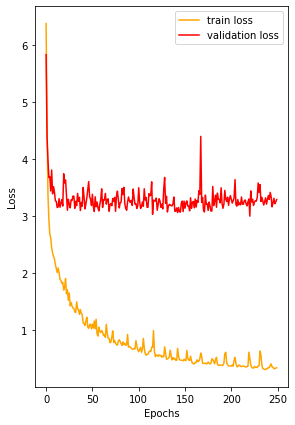

In [13]:
# loss plots
plt.figure(figsize=(10, 7))
plt.subplot(121)
plt.plot(train_loss, color='orange', label='train loss')
plt.plot(val_loss, color='red', label='validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
# plt.savefig('../outputs/plots/loss.png')
plt.show()

In [14]:
# helper function for data visualization
def visualize(**images):
    """PLot images in one row."""
    n = len(images)
    plt.figure(figsize=(16, 5))
    for i, (name, image) in enumerate(images.items()):
        plt.subplot(1, n, i + 1)
        plt.xticks([])
        plt.yticks([])
        plt.title(' '.join(name.split('_')).title())
        plt.imshow(image)
    plt.show()

C:\Users\CEK\Anaconda3\envs\tf\lib\site-packages\ipykernel_launcher.py:237: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


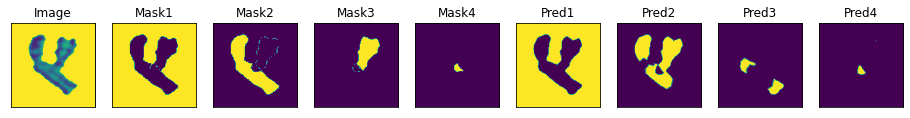

In [15]:
for x, y in val_data_loader:
    
    x = x.to(device)
    y= y.to(device)
    pred= model(x)
#     print(pred)
   
    x= x[0].permute(1,2,0).to("cpu")
    
    pred= pred[0].permute(1, 2, 0).to("cpu")
    pred= pred.detach().numpy()
#     print(pred.shape)
    y= y[0].permute(1, 2, 0).to("cpu")
    
#     image= x
    
    visualize(
        image=x,
        mask1= y[..., 0].squeeze(),
        mask2= y[..., 1].squeeze(),
        mask3= y[..., 2].squeeze(),
        mask4= y[..., 3].squeeze(),
        
        pred1= pred[..., 0].squeeze(),
        pred2= pred[..., 1].squeeze(),
        pred3= pred[..., 2].squeeze(),
        pred4= pred[..., 3].squeeze(),
    )
#     print(mask[..., 0].squeeze())
    
    
    break

C:\Users\CEK\Anaconda3\envs\tf\lib\site-packages\ipykernel_launcher.py:237: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


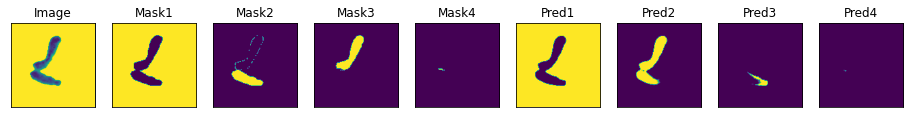

In [16]:
for x, y in test_data_loader:
    
    x = x.to(device)
    y= y.to(device)
    pred= model(x)
#     print(pred)
   
    x= x[0].permute(1,2,0).to("cpu")
    
    pred= pred[0].permute(1, 2, 0).to("cpu")
    pred= pred.detach().numpy()
#     print(pred.shape)
    y= y[0].permute(1, 2, 0).to("cpu")
    
#     image= x
    
    visualize(
        image=x,
        mask1= y[..., 0].squeeze(),
        mask2= y[..., 1].squeeze(),
        mask3= y[..., 2].squeeze(),
        mask4= y[..., 3].squeeze(),
        
        pred1= pred[..., 0].squeeze(),
        pred2= pred[..., 1].squeeze(),
        pred3= pred[..., 2].squeeze(),
        pred4= pred[..., 3].squeeze(),
    )
#     print(mask[..., 0].squeeze())
    
    
    break

# **Evaluating Model**

In [19]:
def get_accuracy(SR,GT,threshold=0.5):
    SR = SR > threshold
    GT = GT == torch.max(GT)
    corr = torch.sum(SR==GT)
    tensor_size = SR.size(0)*SR.size(1)*SR.size(2)*SR.size(3)
    acc = float(corr)/float(tensor_size)

    return acc


def get_sensitivity(pred, target, threshold=0.5):
    # Apply threshold to predicted image
    pred_binary = (pred > threshold).float()

    # Compute true positives and false negatives
    tp = torch.sum((pred_binary == 1) & (target == 1)).float()
    fn = torch.sum((pred_binary == 0) & (target == 1)).float()

    # Compute sensitivity (recall)
    
    sensitivity = float(torch.sum(tp))/(float(torch.sum(tp+fn)) + 1e-6)

    return sensitivity



def get_specificity(pred, target, threshold=0.5):
    # Apply threshold to predicted image
    pred_binary = (pred > threshold).float()

    # Compute true negatives and false positives
    tn = torch.sum((pred_binary == 0) & (target == 0)).float()
    fp = torch.sum((pred_binary == 1) & (target == 0)).float()

    # Compute specificity
    specificity = float(torch.sum(tn))/(float(torch.sum(tn+fp)) + 1e-6)

    return specificity




def get_precision(pred, target, threshold=0.5):
    # Apply threshold to predicted image
    pred_binary = (pred > threshold).float()

    # Compute true positives and false positives
    tp = torch.sum((pred_binary == 1) & (target == 1)).float()
    fp = torch.sum((pred_binary == 1) & (target == 0)).float()

    # Compute precision
    precision = float(torch.sum(tp))/(float(torch.sum(tp+fp)) + 1e-6)

    return precision



def get_F1(pred, target, threshold=0.5):
    # Apply threshold to predicted image
    pred_binary = (pred > threshold).float()

    # Compute true positives, false positives, and false negatives
    tp = torch.sum((pred_binary == 1) & (target == 1)).float()
    fp = torch.sum((pred_binary == 1) & (target == 0)).float()
    fn = torch.sum((pred_binary == 0) & (target == 1)).float()

    # Compute precision, recall, and F1 score
    precision = tp / (tp + fp + 1e-6)
    recall = tp / (tp + fn + 1e-6)
    f1_score = float(2 * precision * recall / (precision + recall + 1e-6))

    return f1_score



def get_JS(pred, target, threshold=0.5):
    # Apply threshold to predicted image
    pred_binary = (pred > threshold).float()

    # Compute intersection and union
    intersection = torch.sum((pred_binary == 1) & (target == 1)).float()
    union = torch.sum((pred_binary == 1) | (target == 1)).float()

    # Compute Jaccard similarity
    JS = float(intersection / (union + 1e-6))

    return JS



def get_DC(pred, target, threshold=0.5):
    # Apply threshold to predicted image
    pred_binary = (pred > threshold).float()

    # Compute intersection and sum of pixels in predicted and target masks
    intersection = torch.sum((pred_binary == 1) & (target == 1)).float()
    sum_masks = torch.sum(pred_binary == 1) + torch.sum(target == 1)

    # Compute Dice coefficient
    DC = float(2 * intersection / (sum_masks + 1e-6))

    return DC


def get_TPR(SR, GT, threshold=0.5):
    # Apply the threshold to the predicted segmentation map
    SR = SR > threshold

    # Convert the ground truth segmentation map to binary
    GT = GT == torch.max(GT, dim=1, keepdim=True)[0]

    # Initialize a list to store the TPR values for each channel
    TPR_list = []

    # Calculate the TPR for each channel separately
    for c in range(SR.size(1)):
        # Calculate the number of true positive pixels for this channel
        TP = torch.sum((SR[:, c] == 1) & (GT[:, c] == 1))

        # Calculate the number of positive pixels in the ground truth for this channel
        P = torch.sum(GT[:, c] == 1)

        # Calculate the true positive rate for this channel
        TPR = TP.float() / P.float()

        # Append the TPR value to the list
        TPR_list.append(TPR.item())

    # Calculate the average TPR across all channels
    avg_TPR = sum(TPR_list) / len(TPR_list)
    avg_TPR= float(avg_TPR)

    return avg_TPR






def get_TNR(SR, GT, threshold=0.5):
    # Apply the threshold to the predicted segmentation map
    SR = SR > threshold

    # Convert the ground truth segmentation map to binary
    GT = GT == torch.max(GT, dim=1, keepdim=True)[0]

    # Invert the binary maps to obtain the negative maps
    SR_neg = ~SR
    GT_neg = ~GT

    # Initialize a list to store the TNR values for each channel
    TNR_list = []

    # Calculate the TNR for each channel separately
    for c in range(SR.size(1)):
        # Calculate the number of true negative pixels for this channel
        TN = torch.sum((SR_neg[:, c] == 1) & (GT_neg[:, c] == 1))

        # Calculate the number of negative pixels in the ground truth for this channel
        N = torch.sum(GT_neg[:, c] == 1)

        # Calculate the true negative rate for this channel
        TNR = TN.float() / N.float()

        # Append the TNR value to the list
        TNR_list.append(TNR.item())

    # Calculate the average TNR across all channels
    avg_TNR = sum(TNR_list) / len(TNR_list)
    avg_TNR= float(avg_TNR)

    return avg_TNR



def get_FPR(SR, GT, threshold=0.5):
    # Apply the threshold to the predicted segmentation map
    SR = SR > threshold

    # Convert the ground truth segmentation map to binary
    GT = GT == torch.max(GT, dim=1, keepdim=True)[0]

    # Initialize a list to store the FPR values for each channel
    FPR_list = []

    # Calculate the FPR for each channel separately
    for c in range(SR.size(1)):
        # Calculate the number of false positive pixels for this channel
        FP = torch.sum((SR[:, c] == 1) & (GT[:, c] == 0))

        # Calculate the number of negative pixels in the ground truth for this channel
        N = torch.sum(GT[:, c] == 0)

        # Calculate the false positive rate for this channel
        FPR = FP.float() / N.float()

        # Append the FPR value to the list
        FPR_list.append(FPR.item())

    # Calculate the average FPR across all channels
    avg_FPR = sum(FPR_list) / len(FPR_list)
    avg_FPR= float(avg_FPR)

    return avg_FPR



def get_FNR(SR, GT, threshold=0.5):
    # Apply the threshold to the predicted segmentation map
    SR = SR > threshold

    # Convert the ground truth segmentation map to binary
    GT = GT == torch.max(GT, dim=1, keepdim=True)[0]

    # Initialize a list to store the FNR values for each channel
    FNR_list = []

    # Calculate the FNR for each channel separately
    for c in range(SR.size(1)):
        # Calculate the number of false negative pixels for this channel
        FN = torch.sum((SR[:, c] == 0) & (GT[:, c] == 1))

        # Calculate the number of positive pixels in the ground truth for this channel
        P = torch.sum(GT[:, c] == 1)

        # Calculate the false negative rate for this channel
        FNR = FN.float() / P.float()

        # Append the FNR value to the list
        FNR_list.append(FNR.item())

    # Calculate the average FNR across all channels
    avg_FNR = sum(FNR_list) / len(FNR_list)
    avg_FNR= float(avg_FNR)

    return avg_FNR


def get_recall(SR, GT, threshold=0.5):
    # Apply the threshold to the predicted segmentation map
    SR = SR > threshold

    # Convert the ground truth segmentation map to binary
    GT = GT == torch.max(GT, dim=1, keepdim=True)[0]

    # Initialize a list to store the recall values for each channel
    recall_list = []

    # Calculate the recall for each channel separately
    for c in range(SR.size(1)):
        # Calculate the number of true positive pixels for this channel
        TP = torch.sum((SR[:, c] == 1) & (GT[:, c] == 1))

        # Calculate the number of positive pixels in the ground truth for this channel
        P = torch.sum(GT[:, c] == 1)

        # Calculate the recall for this channel
        recall = TP.float() / P.float()

        # Append the recall value to the list
        recall_list.append(recall.item())

    # Calculate the average recall across all channels
    avg_recall = sum(recall_list) / len(recall_list)
    avg_recall= float(avg_recall)

    return avg_recall



In [20]:
accuracy=[]
precision=[]
recall=[]
Jaccard_Similarity= []
dice_coefficient=[]
TPR=[]
TNR=[]
FPR=[]
FNR=[]



for x, y in test_data_loader:
    
    x = x.to(device)
    y= y.to(device)
    pred= model(x)
    
    GT= y
    SR= pred
    
    
    accuracy.append(get_accuracy(SR,GT,threshold=0.5))
    precision.append(get_precision(SR, GT, threshold=0.5))
    recall.append(get_recall(SR, GT, threshold=0.5))
    TPR.append(get_TPR(SR, GT, threshold=0.5))
    TNR.append(get_TNR(SR, GT, threshold=0.5))
    FPR.append(get_FPR(SR, GT, threshold=0.5))
    FNR.append(get_FNR(SR, GT, threshold=0.5))
    Jaccard_Similarity.append(get_JS(SR, GT, threshold=0.5))
    dice_coefficient.append(get_DC(SR, GT, threshold=0.5))
    
    
    


C:\Users\CEK\Anaconda3\envs\tf\lib\site-packages\ipykernel_launcher.py:237: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


In [22]:
print("Accuracy : ", np.mean(accuracy))
print("Precision : ", np.mean(precision))
print("Recall", np.mean(recall))


print("TPR: ", np.mean(TPR))
print("TNR: ", np.mean(TNR))
print("FPR: ", np.mean(FPR))
print("FNR: ",np.mean(FNR))

print("IOU : ", np.mean(Jaccard_Similarity))
print("Dice : ", np.mean(dice_coefficient))


Accuracy :  0.9715371180062342
Precision :  0.9431332002295116
Recall 0.6615411875230928
TPR:  0.6615411875230928
TNR:  0.9736258166305947
FPR:  0.026374184454110983
FNR:  0.3384588126162528
IOU :  0.895714738754311
Dice :  0.943067486237998
